<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/Basic_test_complete_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# User Parameters

In [4]:
dataset_size = 10000
load_models = False # Loading previously saved model. Retraining models if false.
auto_scale = False # Whether or not to automatically scale the number of kernels to the number of outputs. If False, 2 convolutional kernels are used.

In [5]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models_00/'

# CNN Network 

In [6]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  #model.add(tf.keras.layers.experimental.preprocessing.Normalization()) # Comment out if no normalization of input data
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [7]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [8]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], X_train.shape[2]) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  print(model.summary())
  model.save(filename)
  return model


In [9]:
def getmodel(X_train, y_train, filename, loadmodel=False, autoscale=True):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    if autoscale:
      no_kernels = y_train.shape[1]
    else:
      no_kernels = 2
    model = compile_and_train(X_train, y_train, filename, no_kernels=no_kernels)
    

  return model

# Continous Wave

## Helper functions

In [10]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [11]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [12]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [13]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

### Prediction

In [14]:
def test_and_predict(model, X_test, y_test):
  if X_test.ndim < 3:
    X_test = np.expand_dims(X_test, axis=2)
  performance = model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict, performance


In [15]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

## Main section

In [16]:
df_iterations = makerandom(dataset_size)

In [17]:
traces_clean = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

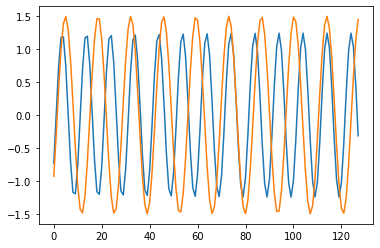

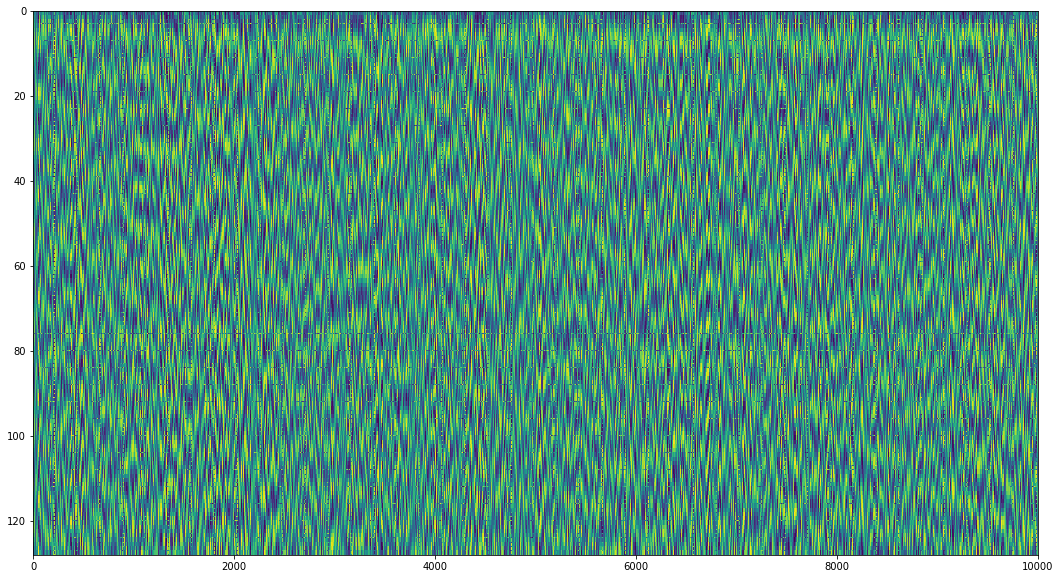

Epoch 1/100
320/320 [==============================] - 21s 8ms/step - loss: 9.9848 - mse: 9.9848 - mae: 1.9810 - val_loss: 1.1182 - val_mse: 1.1182 - val_mae: 0.6780
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 1.3147 - mse: 1.3147 - mae: 0.7764 - val_loss: 0.3300 - val_mse: 0.3300 - val_mae: 0.3872
Epoch 3/100
320/320 [==============================] - 2s 6ms/step - loss: 0.5953 - mse: 0.5953 - mae: 0.5432 - val_loss: 0.1707 - val_mse: 0.1707 - val_mae: 0.2909
Epoch 4/100
320/320 [==============================] - 2s 6ms/step - loss: 0.4586 - mse: 0.4586 - mae: 0.4819 - val_loss: 0.1463 - val_mse: 0.1463 - val_mae: 0.2942
Epoch 5/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3956 - mse: 0.3956 - mae: 0.4451 - val_loss: 0.1230 - val_mse: 0.1230 - val_mae: 0.2619
Epoch 6/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3614 - mse: 0.3614 - mae: 0.4269 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.1996
Epoch 7/1

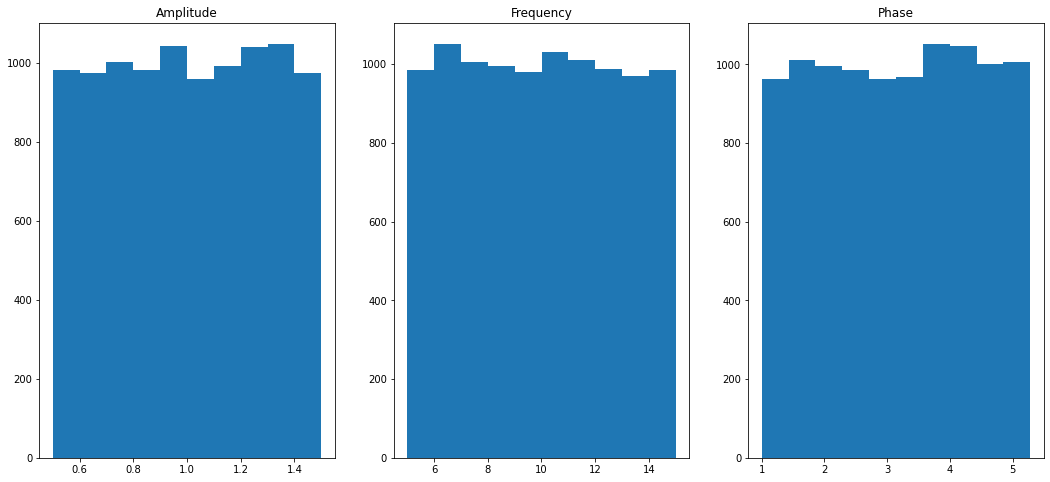

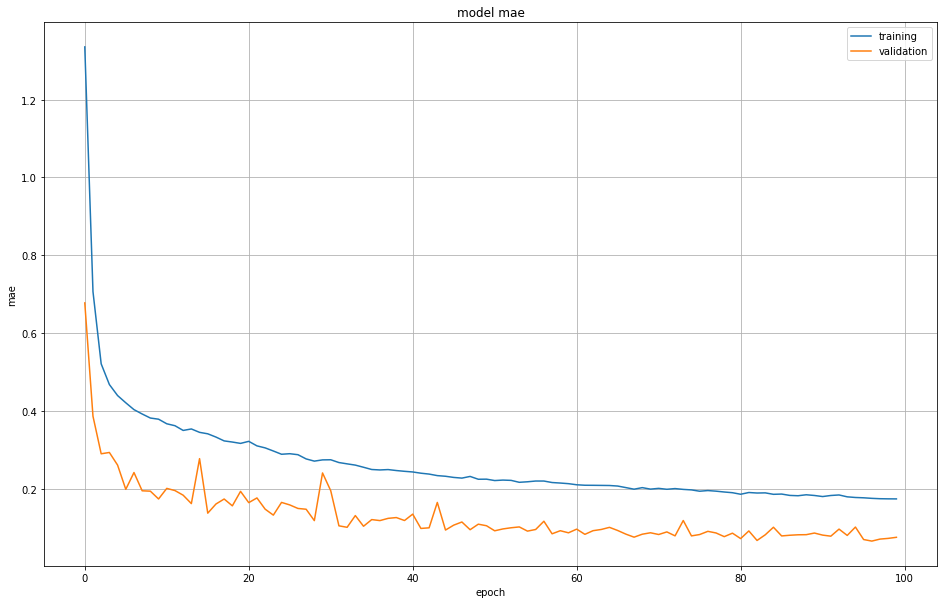

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 2)            66        
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

In [18]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False)
modelname = 'model_cw_clean'
model_cw_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

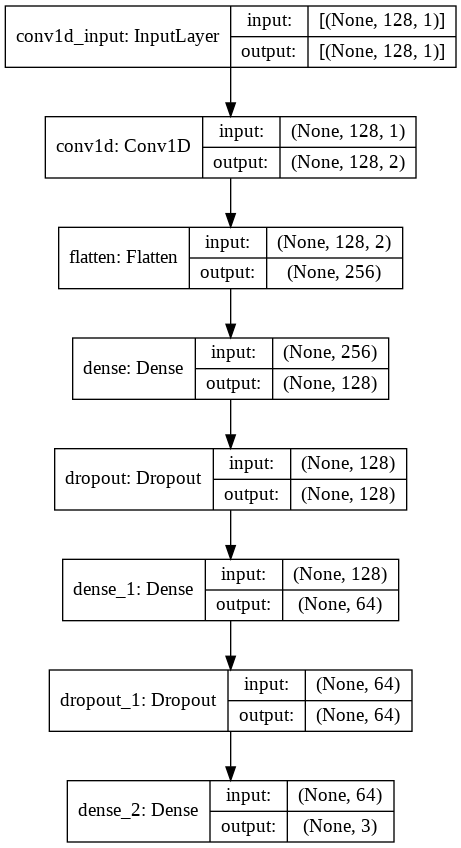

In [19]:
plot_model(model_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0762


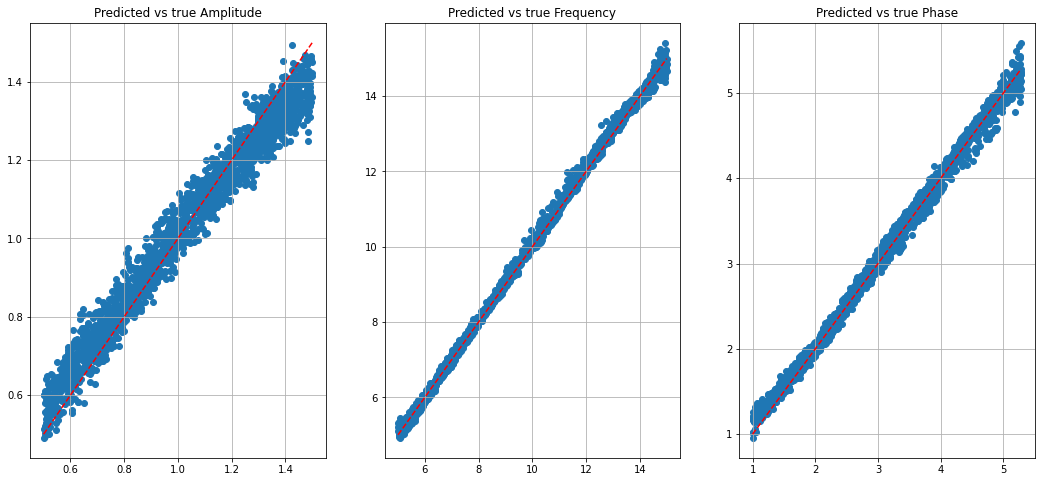

In [20]:
df_y_predict, performance = test_and_predict(model_cw_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [21]:
def addperformance(modelname, performance, df_performance=None):
  if df_performance is None:
    performance.insert(0, modelname)
    df_performance = pd.DataFrame([performance], columns=['ModelName', 'Loss', 'MSE', 'MAE'])
  else:
    df_length = len(df_performance)
    #print(df_performance) 
    #print(performance)
    df_performance.loc[df_length] = [modelname, performance[0], performance[1], performance[2]]
  performance.clear()

  return df_performance

In [22]:
df_performance = addperformance(modelname, performance)

### Noisy

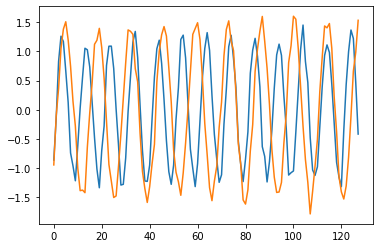

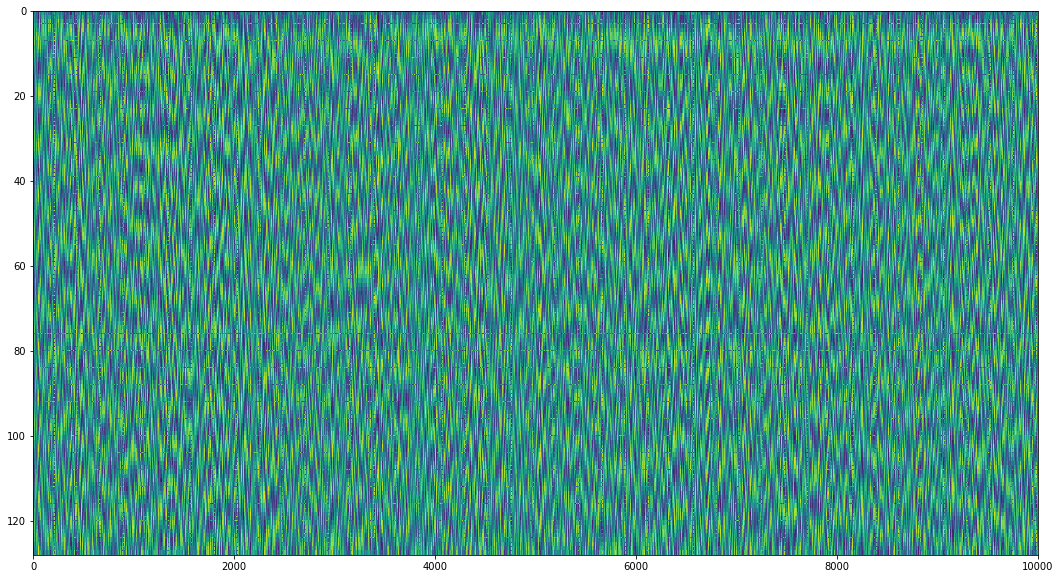

Epoch 1/100
320/320 [==============================] - 4s 8ms/step - loss: 9.2096 - mse: 9.2096 - mae: 1.9346 - val_loss: 1.7358 - val_mse: 1.7358 - val_mae: 0.8553
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 1.6373 - mse: 1.6373 - mae: 0.8801 - val_loss: 0.5684 - val_mse: 0.5684 - val_mae: 0.4995
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.8830 - mse: 0.8830 - mae: 0.6535 - val_loss: 0.2811 - val_mse: 0.2811 - val_mae: 0.3717
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.6579 - mse: 0.6579 - mae: 0.5635 - val_loss: 0.2318 - val_mse: 0.2318 - val_mae: 0.3521
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.6106 - mse: 0.6106 - mae: 0.5362 - val_loss: 0.1753 - val_mse: 0.1753 - val_mae: 0.3040
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5206 - mse: 0.5206 - mae: 0.4918 - val_loss: 0.1525 - val_mse: 0.1525 - val_mae: 0.2798
Epoch 7/10

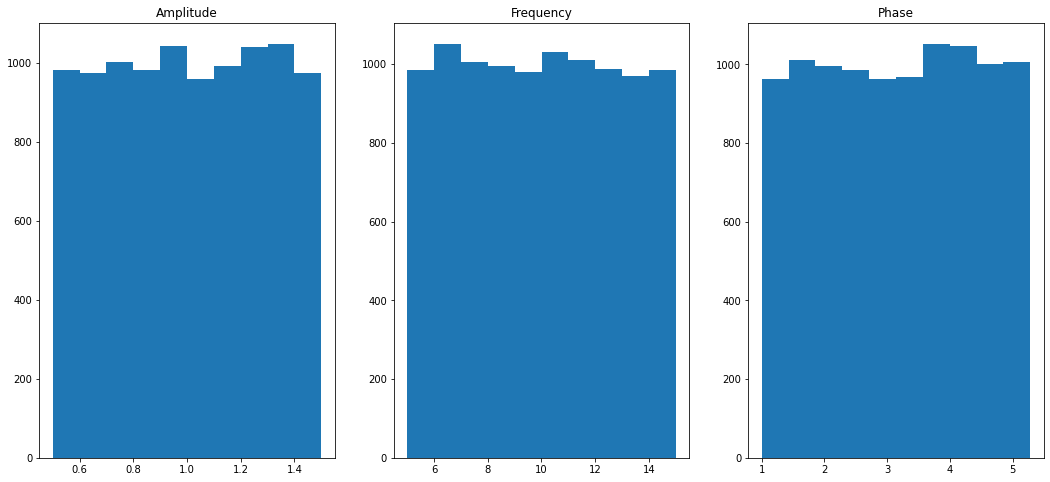

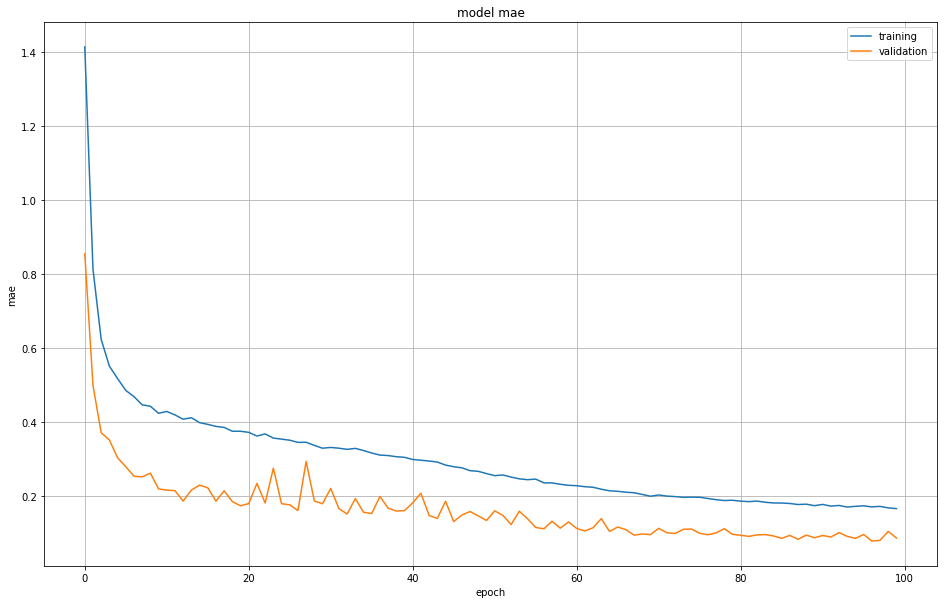

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [23]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=True)
modelname = 'model_cw_noisy'
model_cw_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

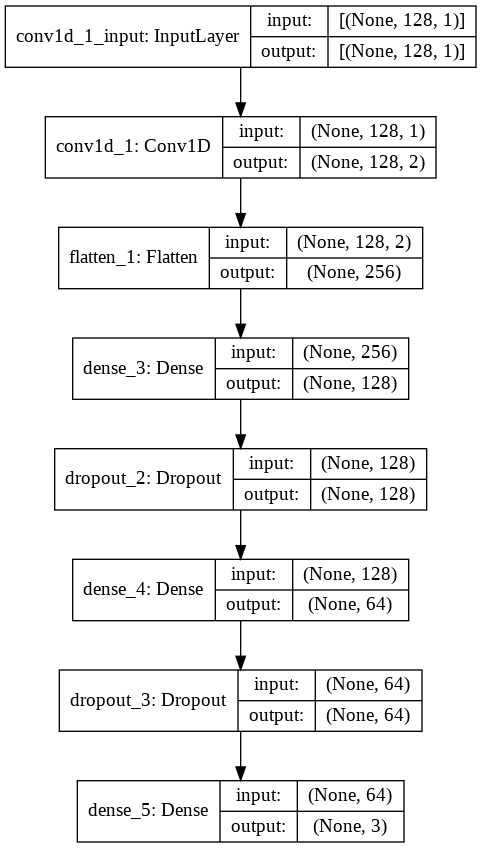

In [24]:
plot_model(model_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0861


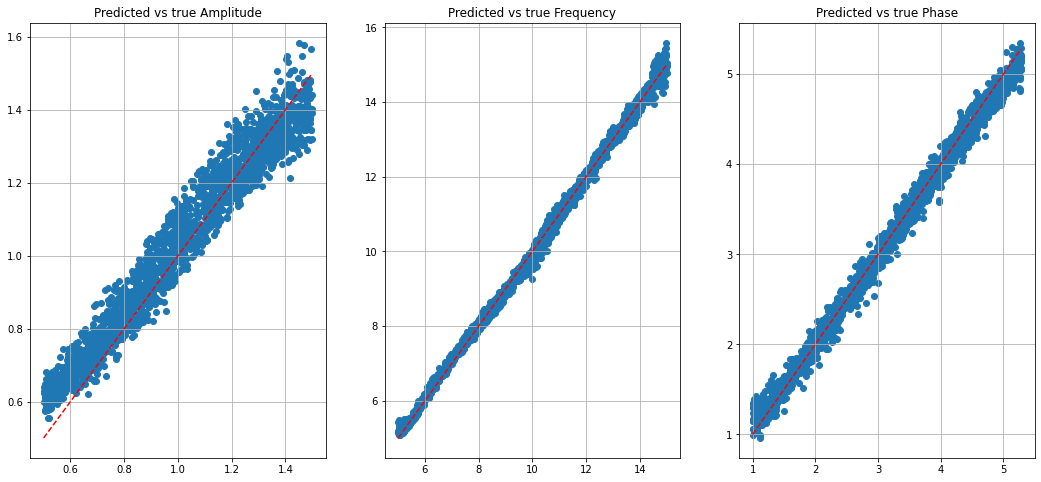

In [25]:
df_y_predict, performance = test_and_predict(model_cw_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [26]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Signal Pulse

## Helper functions

In [27]:
from scipy import signal
from scipy.fft import fft, fftshift

In [28]:
def makepulse(amp, freq, phase, samplingfreq=128, std=9, t_end=1):
  dt = 1/samplingfreq
  #t_end = samples*dt
  samples = t_end/dt
  t_array = np.arange(0, t_end, dt)
  window = signal.windows.gaussian(samples, std)
  y = amp*np.cos(2*np.pi*freq*t_array + phase) * window
  return y

## Main section

In [29]:
pulse_traces_clean = [makepulse(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

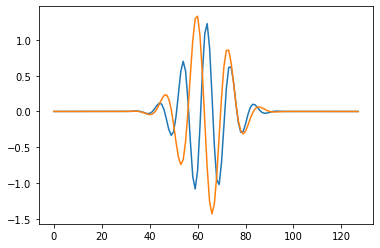

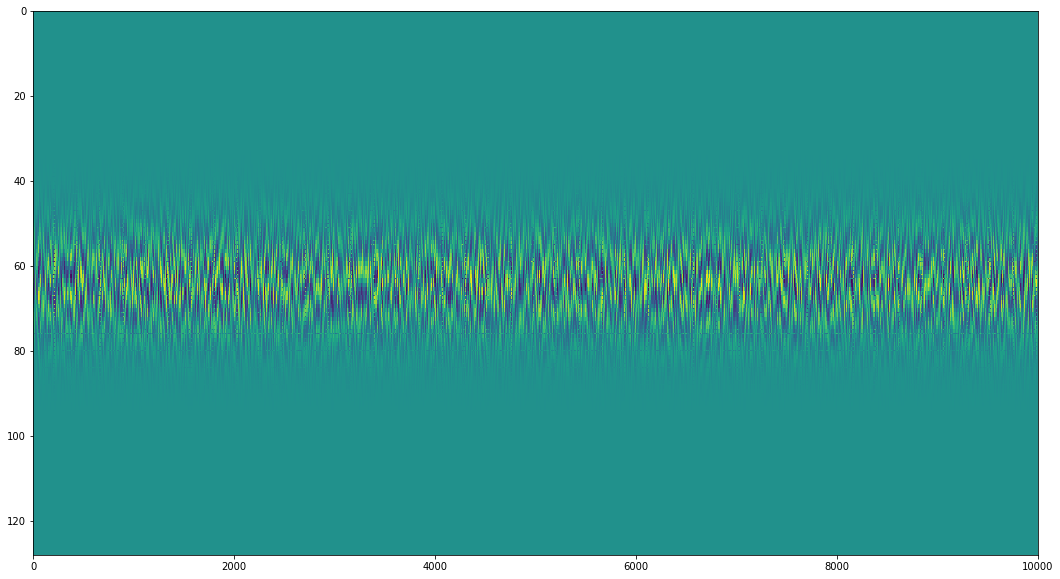

Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 10.9115 - mse: 10.9115 - mae: 2.0779 - val_loss: 0.7229 - val_mse: 0.7229 - val_mae: 0.6015
Epoch 2/100
320/320 [==============================] - 1s 4ms/step - loss: 1.0903 - mse: 1.0903 - mae: 0.7810 - val_loss: 0.5869 - val_mse: 0.5869 - val_mae: 0.5254
Epoch 3/100
320/320 [==============================] - 1s 4ms/step - loss: 0.9234 - mse: 0.9234 - mae: 0.7051 - val_loss: 0.5399 - val_mse: 0.5399 - val_mae: 0.4688
Epoch 4/100
320/320 [==============================] - 1s 4ms/step - loss: 0.8617 - mse: 0.8617 - mae: 0.6648 - val_loss: 0.5334 - val_mse: 0.5334 - val_mae: 0.4702
Epoch 5/100
320/320 [==============================] - 1s 4ms/step - loss: 0.7814 - mse: 0.7814 - mae: 0.6308 - val_loss: 0.5122 - val_mse: 0.5122 - val_mae: 0.4349
Epoch 6/100
320/320 [==============================] - 1s 4ms/step - loss: 0.7940 - mse: 0.7940 - mae: 0.6305 - val_loss: 0.5546 - val_mse: 0.5546 - val_mae: 0.4751
Epoch 7/

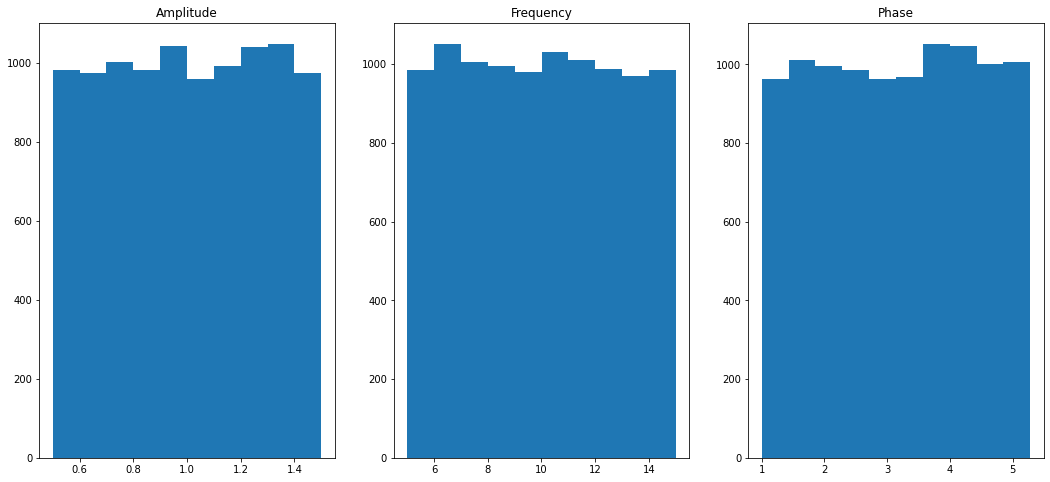

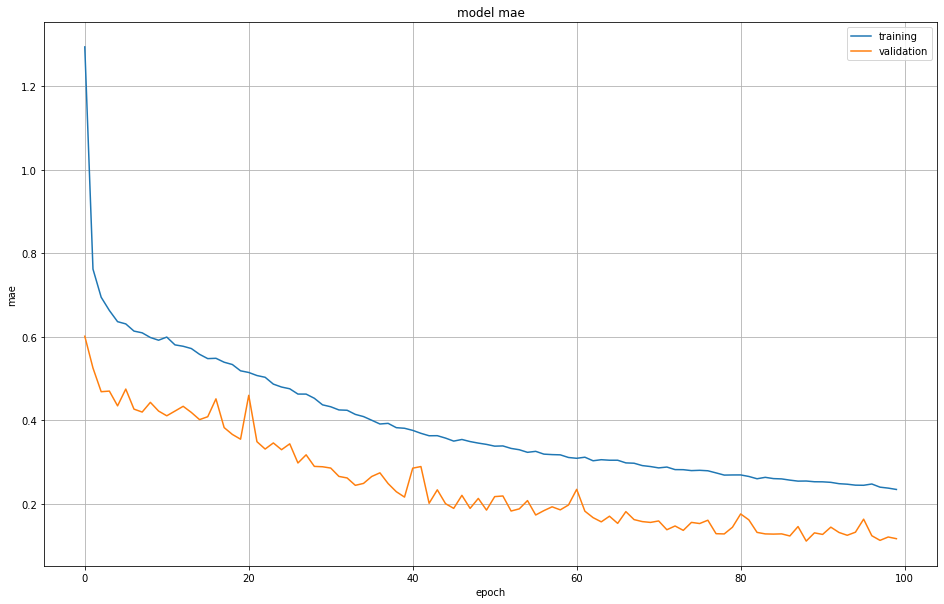

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

In [30]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=False)
modelname = 'model_pulse_clean'
model_pulse_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

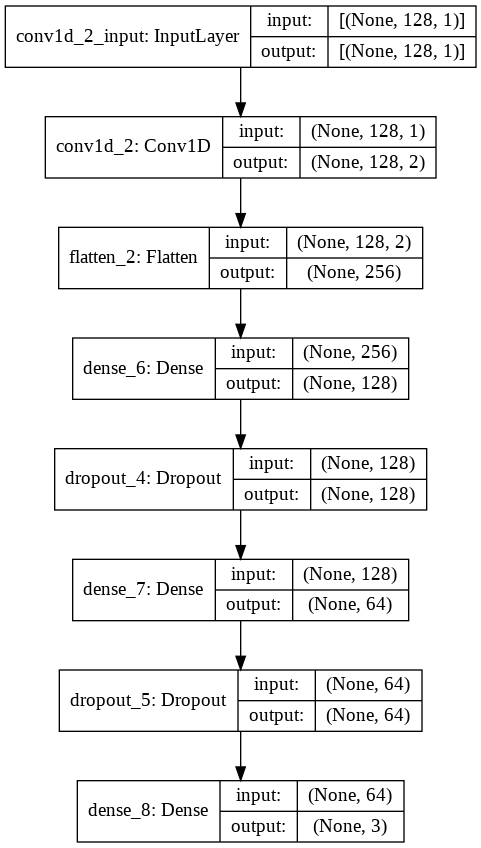

In [31]:
plot_model(model_pulse_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 2ms/step - loss: 0.0291 - mse: 0.0291 - mae: 0.1166


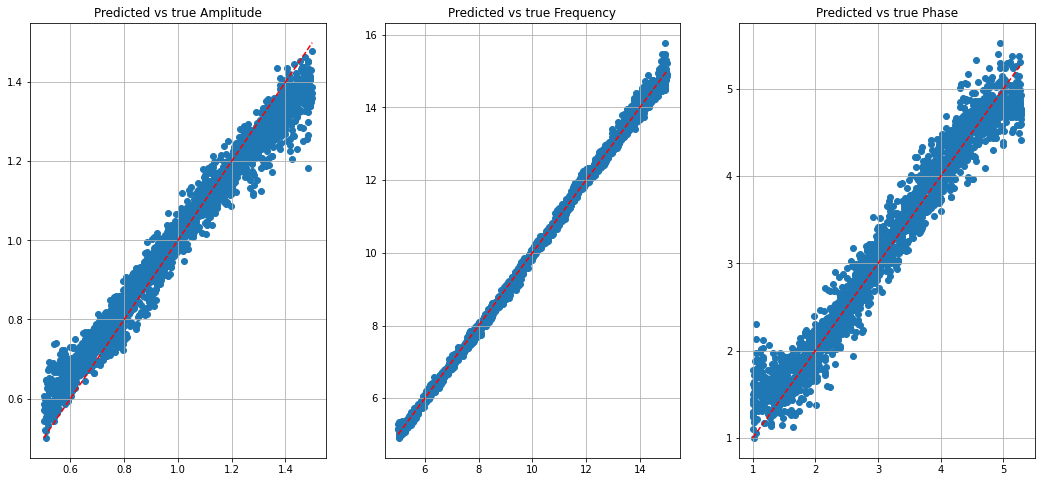

In [32]:
df_y_predict, performance = test_and_predict(model_pulse_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [33]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

In [34]:
df_performance

ModelName      Loss       MSE       MAE
0     model_cw_clean  0.010615  0.010615  0.076196
1     model_cw_noisy  0.013145  0.013145  0.086139
2  model_pulse_clean  0.029061  0.029061  0.116551

### Noisy

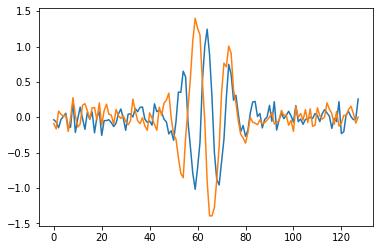

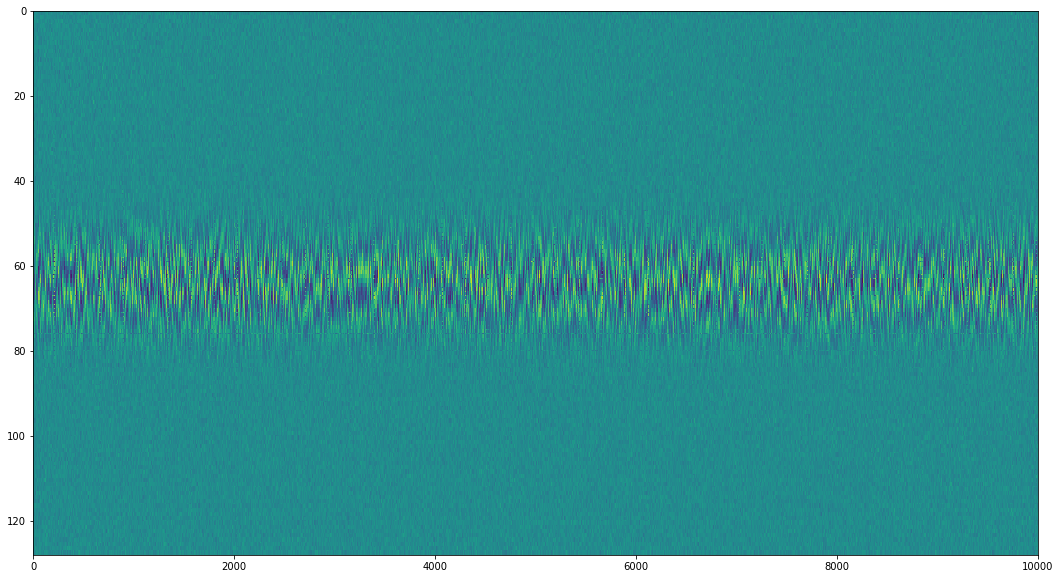

Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 9.8296 - mse: 9.8296 - mae: 2.0158 - val_loss: 0.9019 - val_mse: 0.9019 - val_mae: 0.6763
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.2401 - mse: 1.2401 - mae: 0.8346 - val_loss: 0.6945 - val_mse: 0.6945 - val_mae: 0.5751
Epoch 3/100
320/320 [==============================] - 2s 6ms/step - loss: 1.0280 - mse: 1.0280 - mae: 0.7538 - val_loss: 0.6189 - val_mse: 0.6189 - val_mae: 0.5363
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9421 - mse: 0.9421 - mae: 0.7082 - val_loss: 0.5977 - val_mse: 0.5977 - val_mae: 0.5115
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.8544 - mse: 0.8544 - mae: 0.6713 - val_loss: 0.6068 - val_mse: 0.6068 - val_mae: 0.5263
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.8417 - mse: 0.8417 - mae: 0.6610 - val_loss: 0.5975 - val_mse: 0.5975 - val_mae: 0.5118
Epoch 7/10

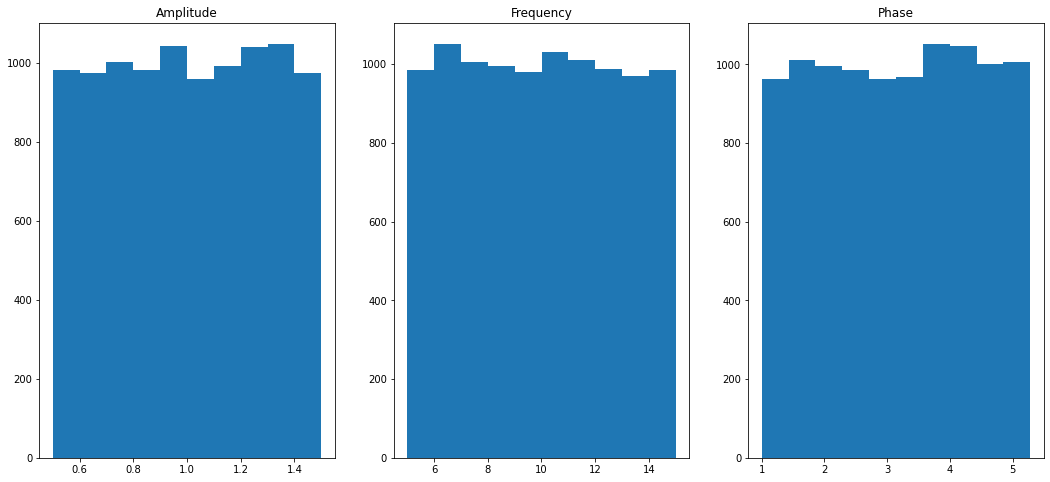

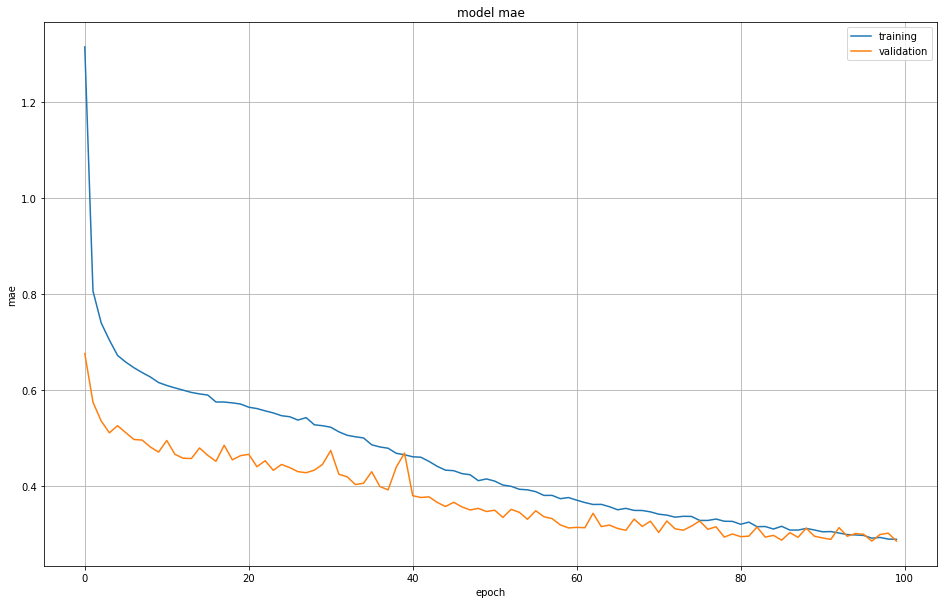

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [35]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=True)
modelname = 'model_pulse_noisy'
model_pulse_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

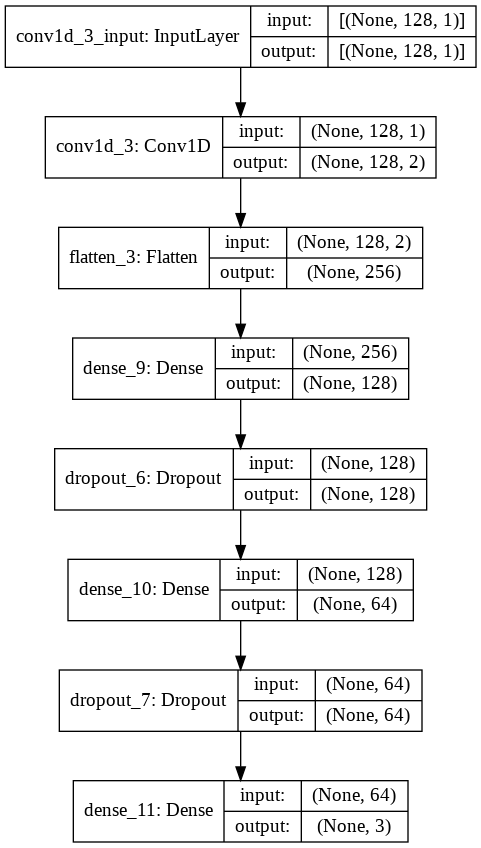

In [36]:
plot_model(model_pulse_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.2208 - mse: 0.2208 - mae: 0.2855


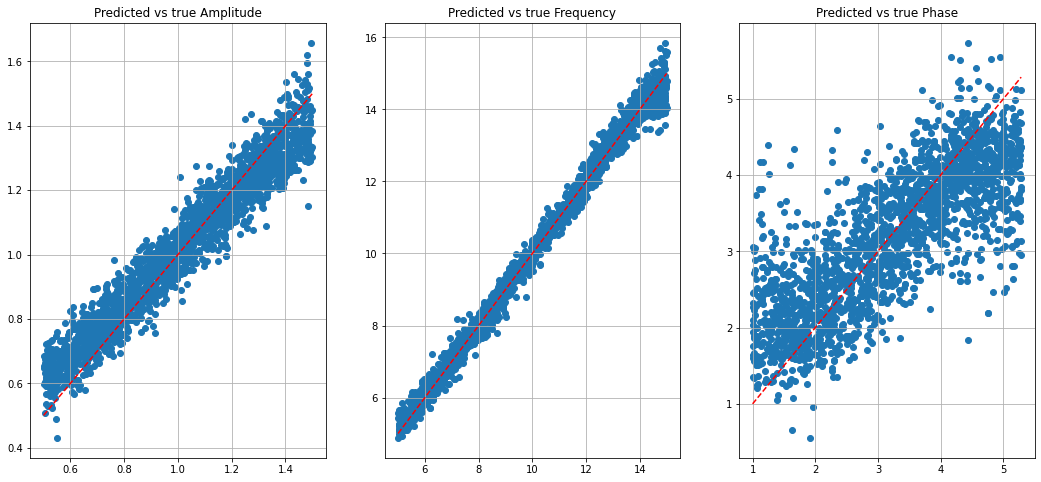

In [37]:
df_y_predict, performance = test_and_predict(model_pulse_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [38]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Pulse with timeshift


## Helper functions

In [39]:
def makepulsetimes(pulse, times, samplingfreq=128, t_end=1):
  dt = 1/samplingfreq
  samples = samplingfreq*t_end
  t_array = np.arange(0, t_end, dt)
  events = np.zeros(samples)
  #print(type(times))
  if type(times) is list:
    #print('this is a list')
    idx = [int(x / dt) for x in times]
  else: 
    idx = int(times / dt)
  events[idx] = 1
  filtered = signal.convolve(events, pulse, mode='same')
  return filtered

In [40]:
def makerandomtimeshift(n, min, max, seed=42):
  rng = np.random.default_rng(seed)
  times = rng.uniform(low=min, high=max, size=n)
  d = {'Timeshift': times}
  return pd.DataFrame(data=d)

## Main section

In [41]:
df_iterations_timeshifts = makerandomtimeshift(len(df_iterations), 0.1, 0.9)
df_iterations_w_timeshifts = df_iterations.join(df_iterations_timeshifts)

In [42]:
pulse_timeshift_traces_clean = [makepulsetimes(row[0], row[1]) for row in zip(pulse_traces_clean, df_iterations_w_timeshifts['Timeshift'])]

### Clean

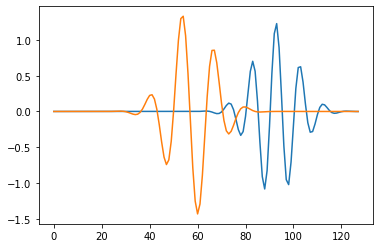

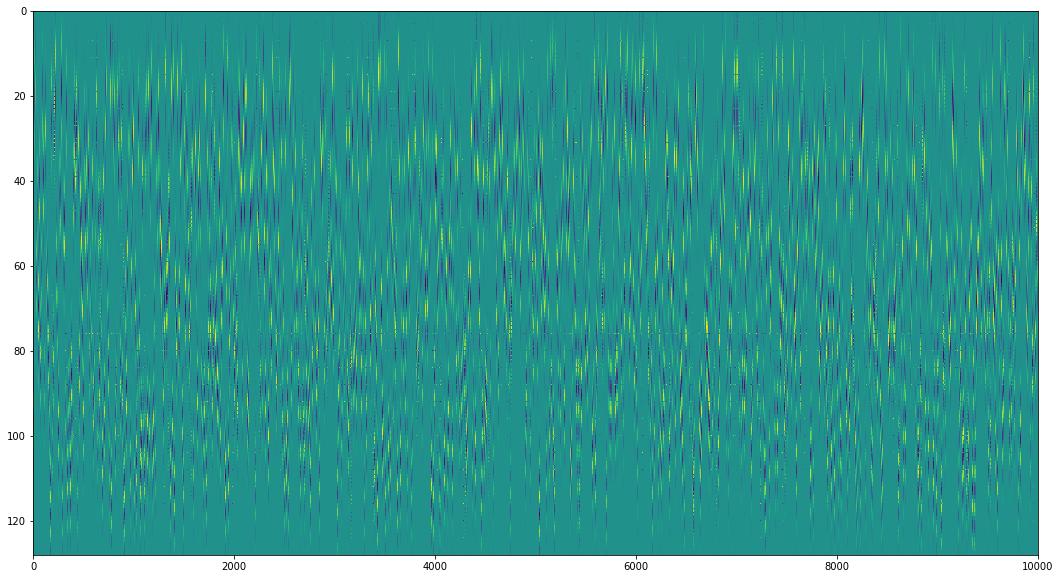

Epoch 1/100
320/320 [==============================] - 3s 7ms/step - loss: 8.2225 - mse: 8.2225 - mae: 1.5781 - val_loss: 0.6622 - val_mse: 0.6622 - val_mae: 0.4845
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 0.8449 - mse: 0.8449 - mae: 0.6201 - val_loss: 0.4117 - val_mse: 0.4117 - val_mae: 0.3954
Epoch 3/100
320/320 [==============================] - 2s 6ms/step - loss: 0.5448 - mse: 0.5448 - mae: 0.4947 - val_loss: 0.2192 - val_mse: 0.2192 - val_mae: 0.2846
Epoch 4/100
320/320 [==============================] - 2s 6ms/step - loss: 0.4450 - mse: 0.4450 - mae: 0.4435 - val_loss: 0.1725 - val_mse: 0.1725 - val_mae: 0.2450
Epoch 5/100
320/320 [==============================] - 2s 6ms/step - loss: 0.3493 - mse: 0.3493 - mae: 0.3883 - val_loss: 0.1154 - val_mse: 0.1154 - val_mae: 0.2082
Epoch 6/100
320/320 [==============================] - 2s 6ms/step - loss: 0.2931 - mse: 0.2931 - mae: 0.3464 - val_loss: 0.1037 - val_mse: 0.1037 - val_mae: 0.2033
Epoch 7/10

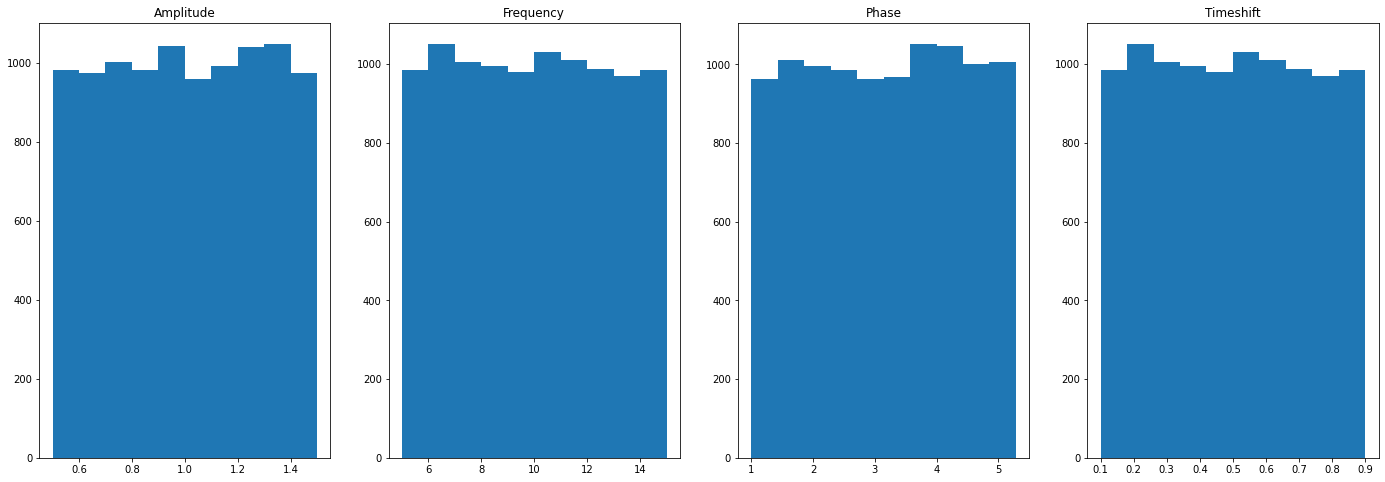

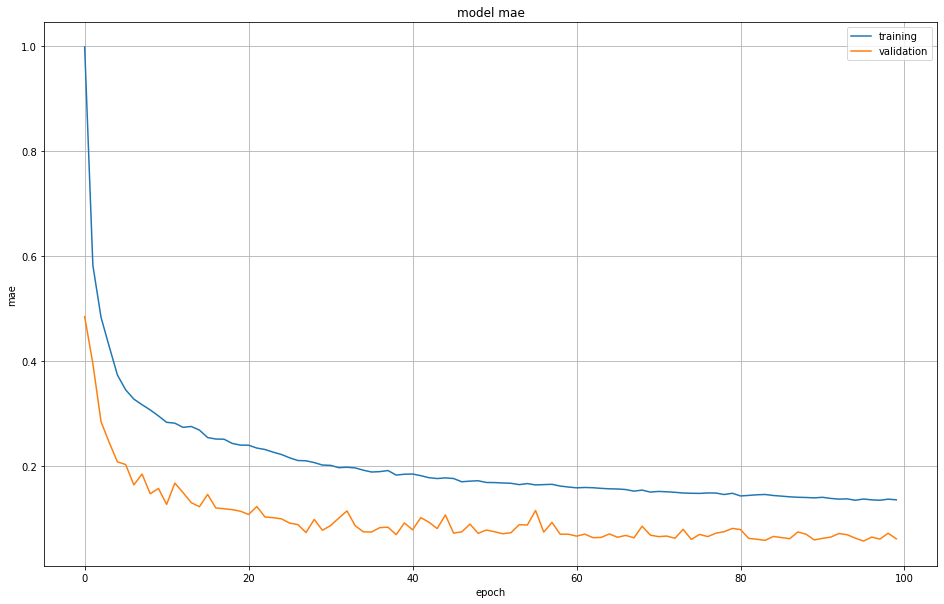

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                

In [43]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=False)
modelname = 'model_pulse_timeshift_clean'
model_pulse_timeshift_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

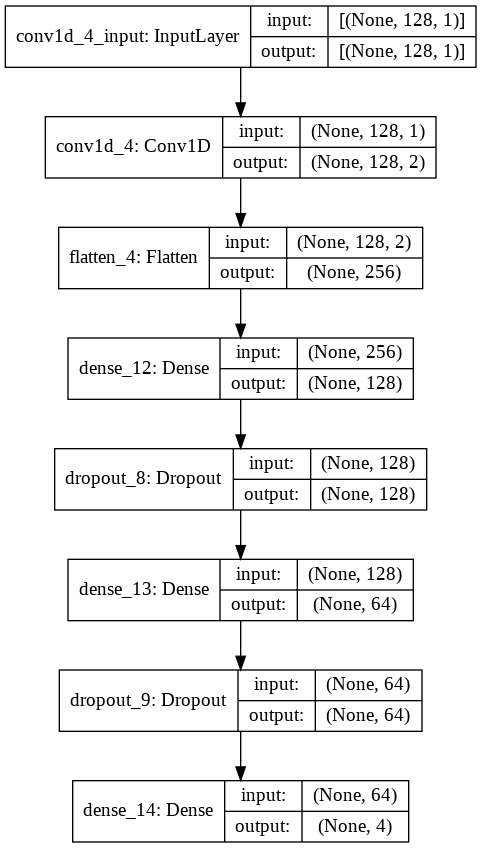

In [44]:
plot_model(model_pulse_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0619


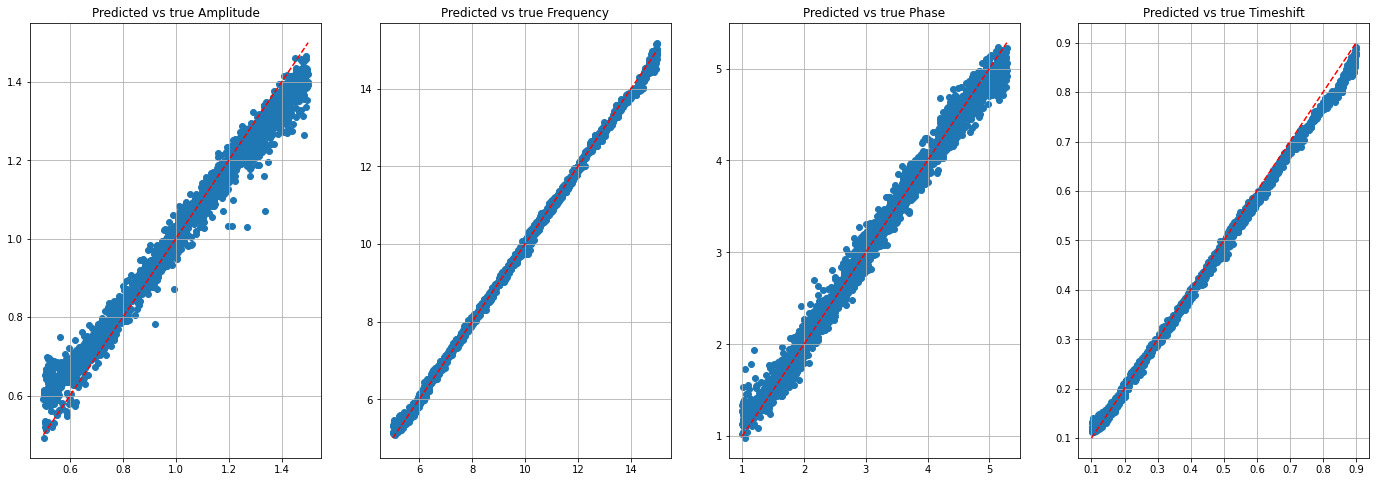

In [45]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [46]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

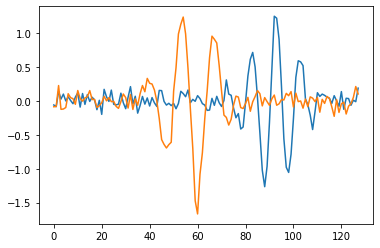

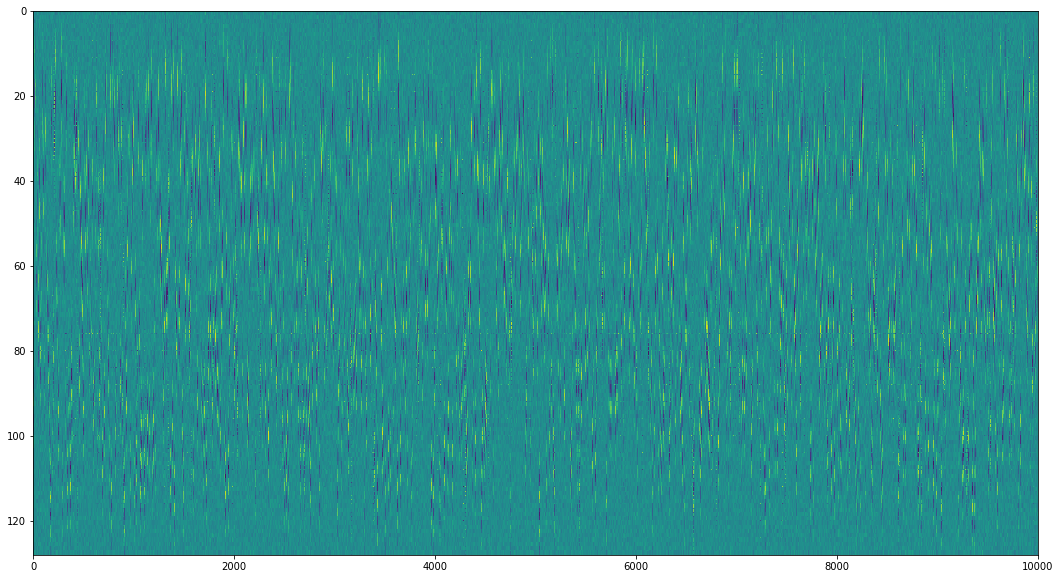

Epoch 1/100
320/320 [==============================] - 3s 7ms/step - loss: 6.7800 - mse: 6.7800 - mae: 1.4641 - val_loss: 0.7132 - val_mse: 0.7132 - val_mae: 0.5227
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9253 - mse: 0.9253 - mae: 0.6498 - val_loss: 0.3346 - val_mse: 0.3346 - val_mae: 0.3546
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5016 - mse: 0.5016 - mae: 0.4831 - val_loss: 0.1895 - val_mse: 0.1895 - val_mae: 0.2619
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3986 - mse: 0.3986 - mae: 0.4189 - val_loss: 0.1500 - val_mse: 0.1500 - val_mae: 0.2361
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3420 - mse: 0.3420 - mae: 0.3783 - val_loss: 0.1319 - val_mse: 0.1319 - val_mae: 0.2204
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3084 - mse: 0.3084 - mae: 0.3534 - val_loss: 0.1023 - val_mse: 0.1023 - val_mae: 0.1912
Epoch 7/10

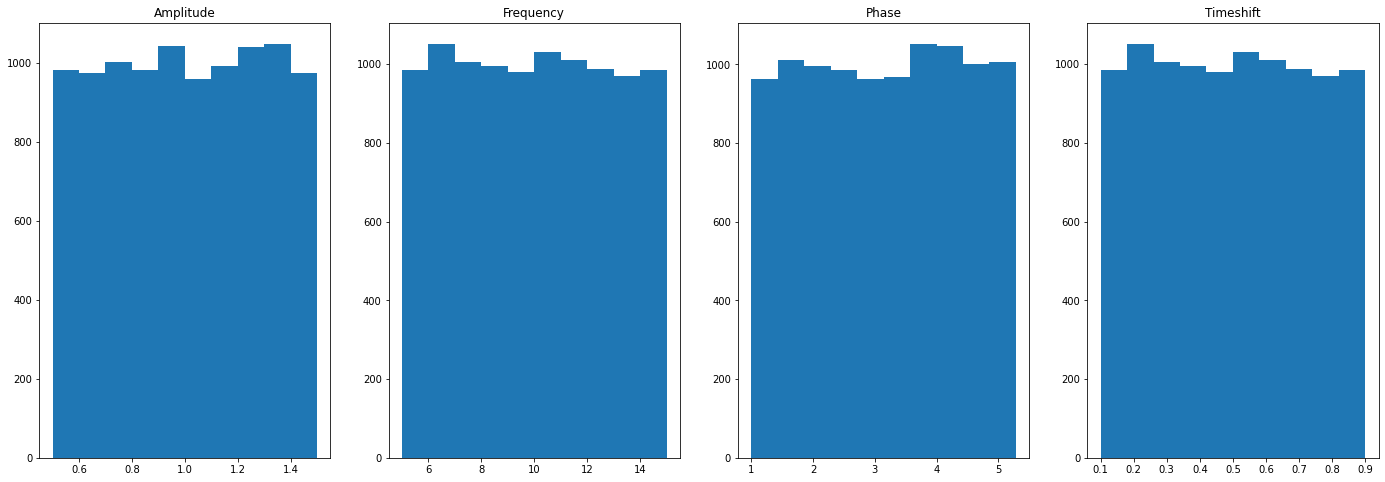

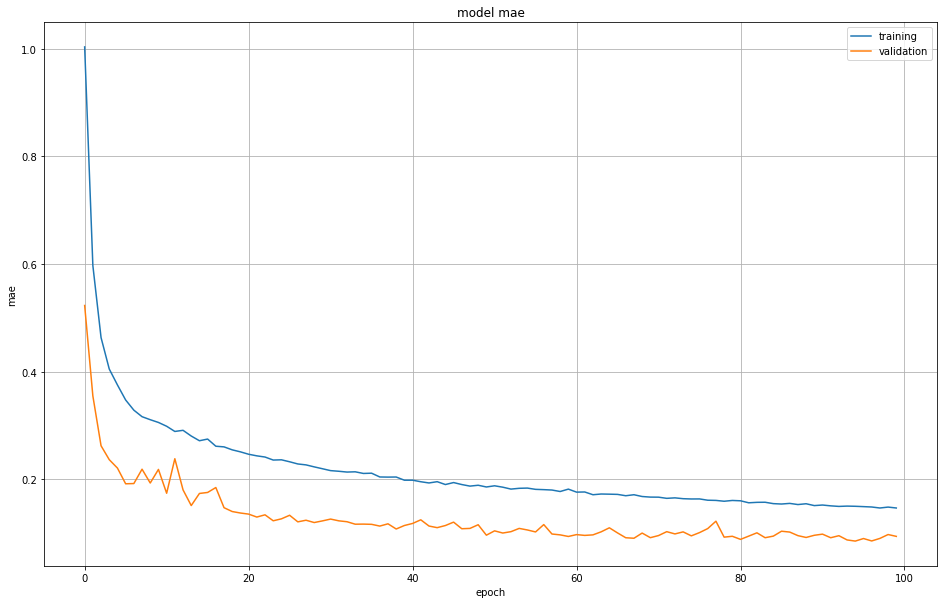

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                

In [47]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=True)
modelname = 'model_pulse_timeshift_noisy'
model_pulse_timeshift_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

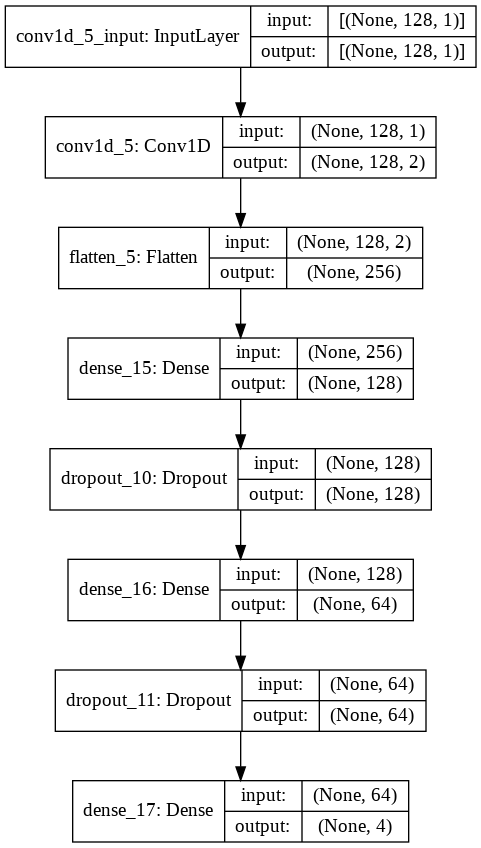

In [48]:
plot_model(model_pulse_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.0921


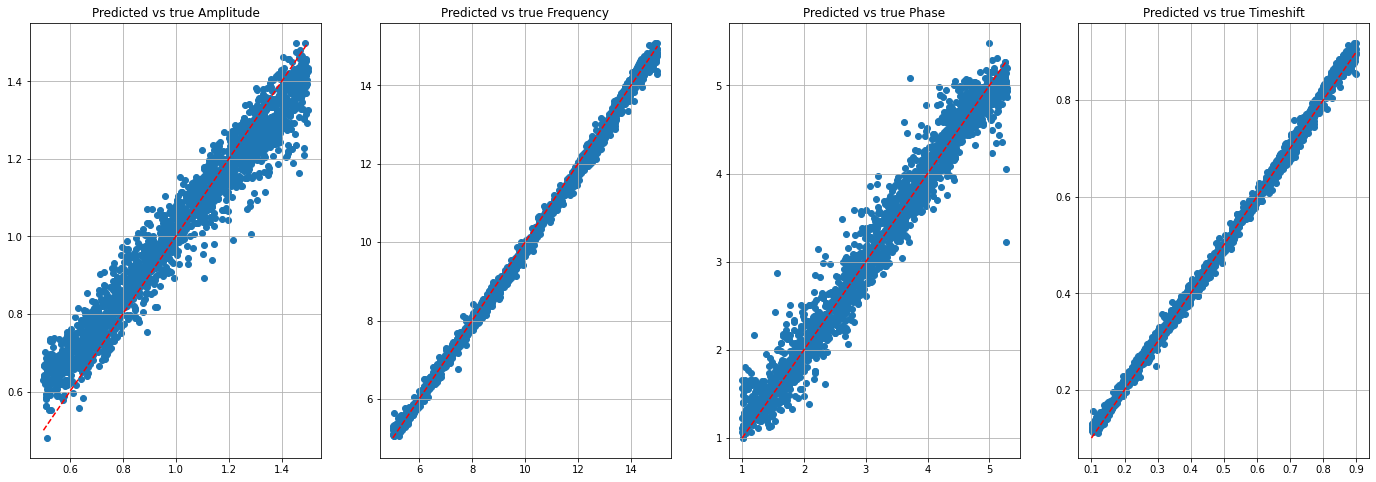

In [49]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [50]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# 2 Pulses with variable timeshift

## Main Section

In [51]:
df_timeshift_1 = makerandomtimeshift(dataset_size, 0.1, 0.4, seed=1)
df_timediff = makerandomtimeshift(dataset_size, 0.1, 0.5, seed=2)
df_timeshift_1.rename(columns={'Timeshift': 'Time1'}, inplace=True)
df_timediff.rename(columns={'Timeshift': 'Timediff'}, inplace=True)
df_2_pulses_timeshift_iterations = df_timeshift_1.join(df_timediff)

In [52]:
timinglist = list((df_2_pulses_timeshift_iterations['Time1'], df_2_pulses_timeshift_iterations['Time1'] + df_2_pulses_timeshift_iterations['Timediff']))
pulse_2_timeshift_traces_clean = [makepulsetimes(row[0], list((row[1], row[2]))) for row in zip(pulse_traces_clean, timinglist[0], timinglist[1])]

In [53]:
df_2_pulses_timeshift_iterations_combined = df_iterations.join(df_2_pulses_timeshift_iterations)

### Clean

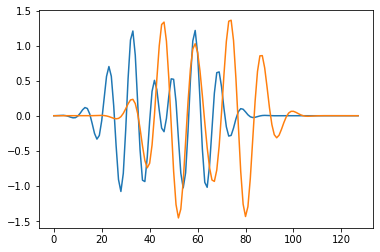

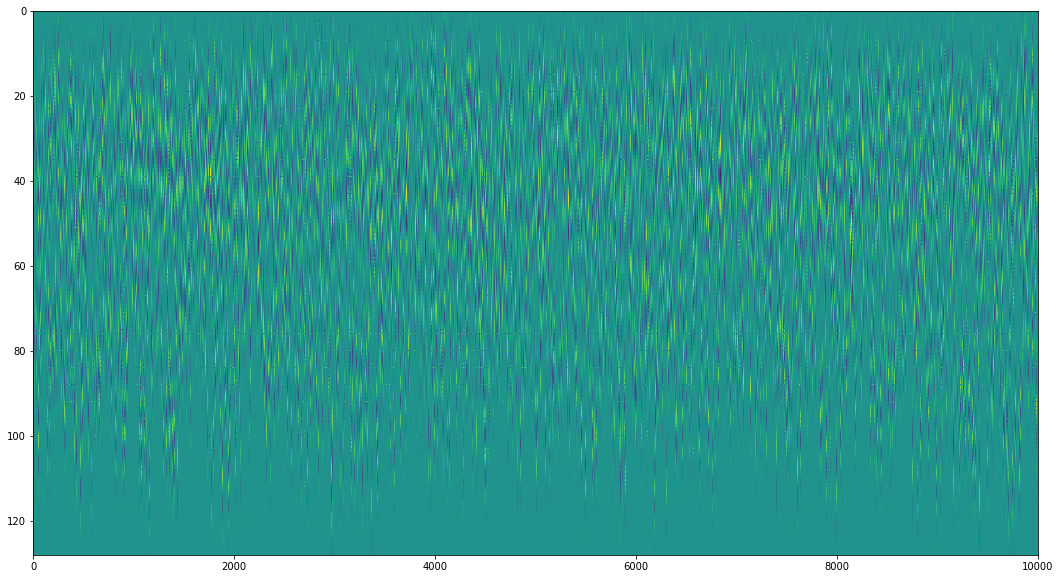

Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 6.4730 - mse: 6.4730 - mae: 1.3520 - val_loss: 0.8543 - val_mse: 0.8543 - val_mae: 0.5457
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.0382 - mse: 1.0382 - mae: 0.6538 - val_loss: 0.5632 - val_mse: 0.5632 - val_mae: 0.4527
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.7020 - mse: 0.7020 - mae: 0.5345 - val_loss: 0.4349 - val_mse: 0.4349 - val_mae: 0.3963
Epoch 4/100
320/320 [==============================] - 1s 5ms/step - loss: 0.5935 - mse: 0.5935 - mae: 0.4823 - val_loss: 0.4137 - val_mse: 0.4137 - val_mae: 0.3886
Epoch 5/100
320/320 [==============================] - 1s 5ms/step - loss: 0.5607 - mse: 0.5607 - mae: 0.4588 - val_loss: 0.3776 - val_mse: 0.3776 - val_mae: 0.3629
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5436 - mse: 0.5436 - mae: 0.4502 - val_loss: 0.3763 - val_mse: 0.3763 - val_mae: 0.3615
Epoch 7/10

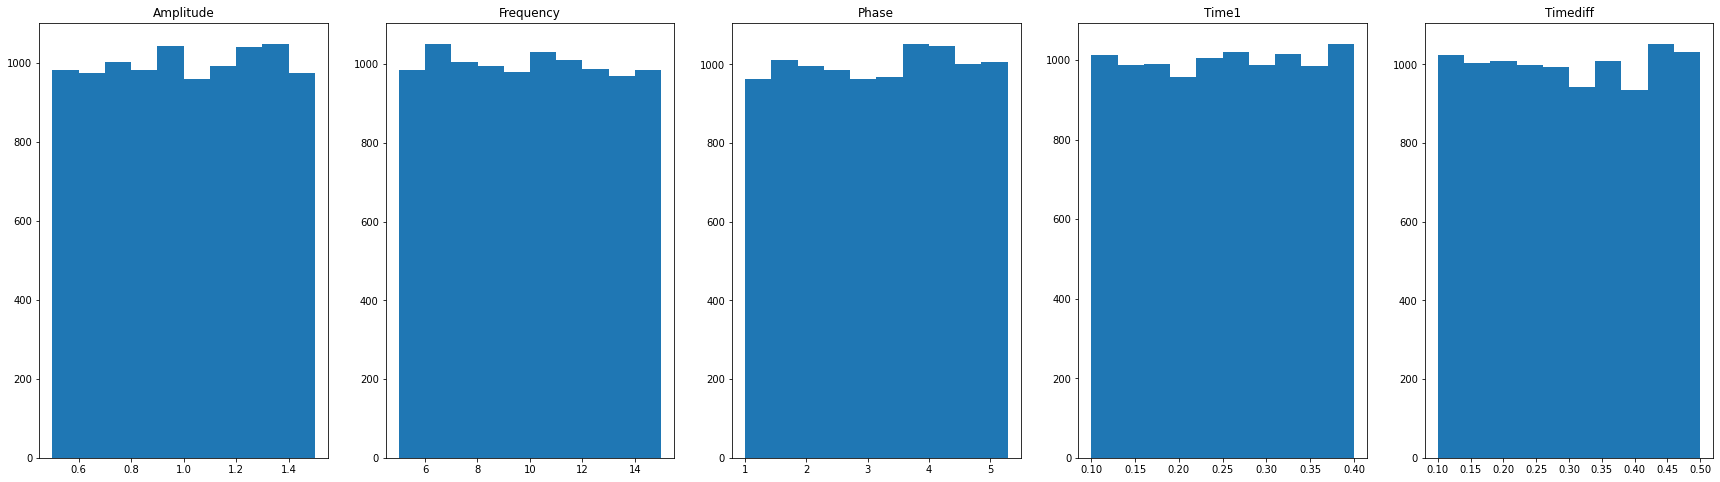

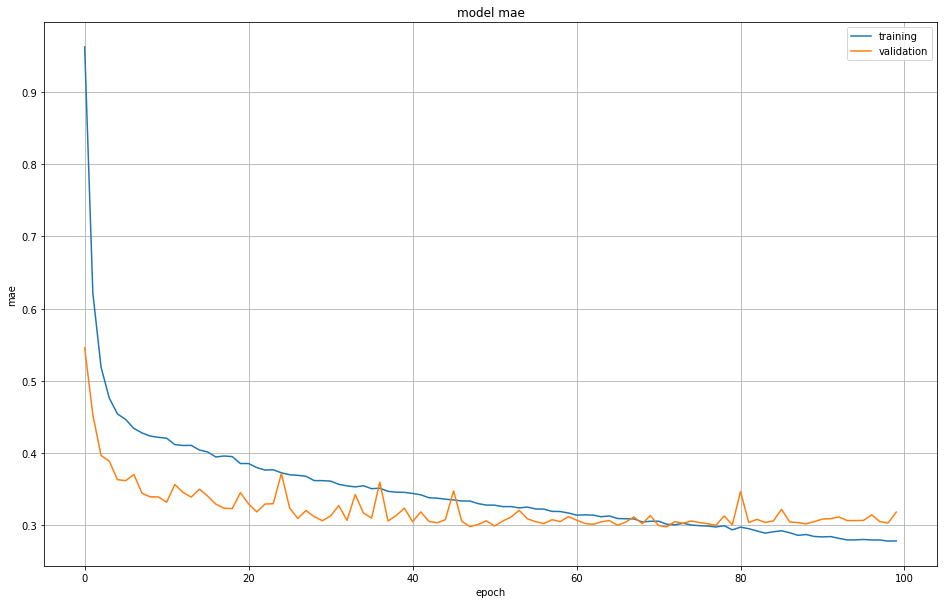

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                

In [54]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=False)
modelname = 'model_2_pulses_timeshift_clean'
model_2_pulses_timeshift_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

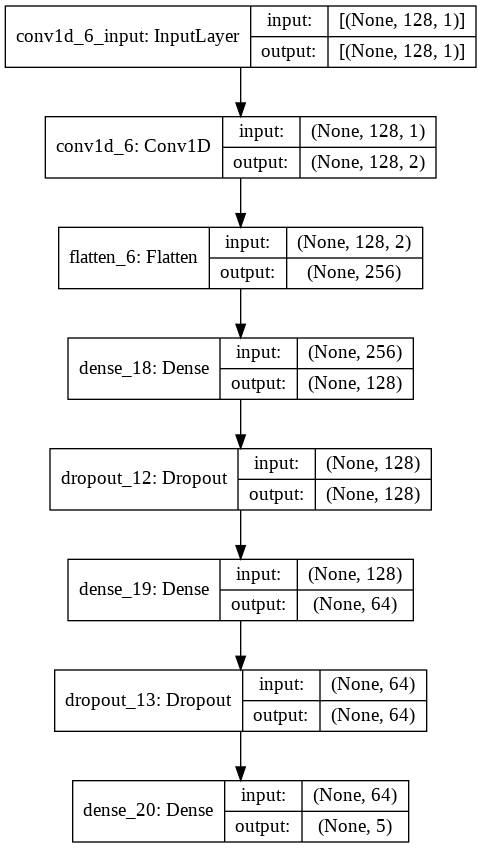

In [55]:
plot_model(model_2_pulses_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.3914 - mse: 0.3914 - mae: 0.3091


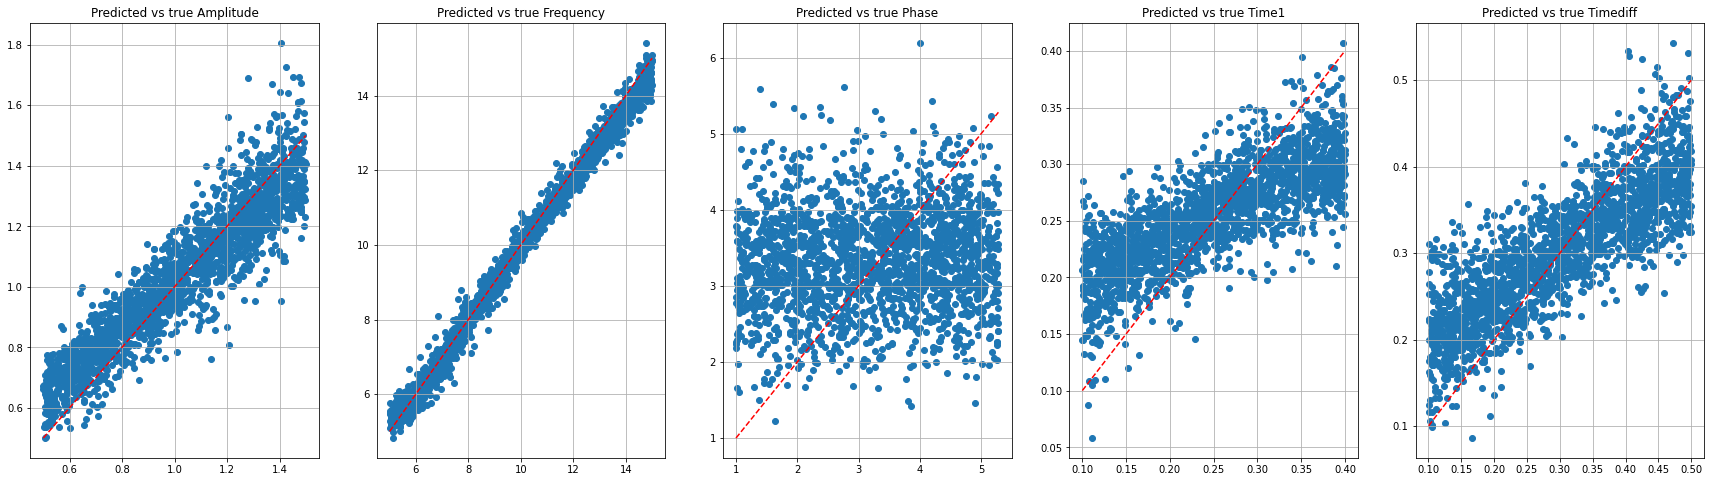

In [56]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [57]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

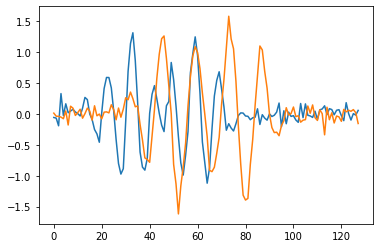

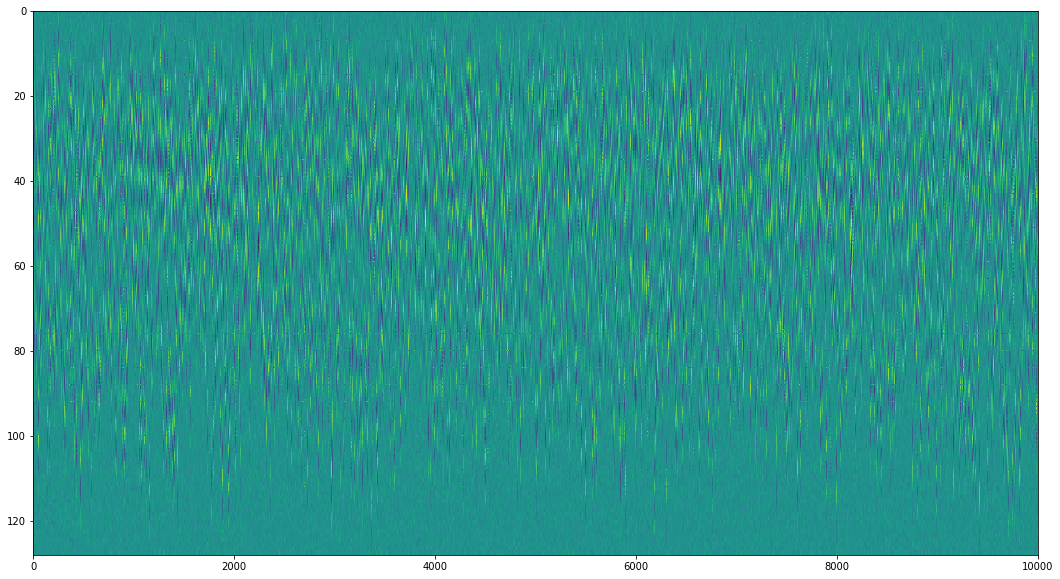

Epoch 1/100
320/320 [==============================] - 3s 7ms/step - loss: 6.1677 - mse: 6.1677 - mae: 1.3481 - val_loss: 0.9673 - val_mse: 0.9673 - val_mae: 0.5897
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.1880 - mse: 1.1880 - mae: 0.6937 - val_loss: 0.8490 - val_mse: 0.8490 - val_mae: 0.5422
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 1.0206 - mse: 1.0206 - mae: 0.6232 - val_loss: 0.7208 - val_mse: 0.7208 - val_mae: 0.5048
Epoch 4/100
320/320 [==============================] - 1s 5ms/step - loss: 0.8489 - mse: 0.8489 - mae: 0.5604 - val_loss: 0.6134 - val_mse: 0.6134 - val_mae: 0.4852
Epoch 5/100
320/320 [==============================] - 1s 4ms/step - loss: 0.7591 - mse: 0.7591 - mae: 0.5301 - val_loss: 0.5607 - val_mse: 0.5607 - val_mae: 0.4623
Epoch 6/100
320/320 [==============================] - 2s 6ms/step - loss: 0.6583 - mse: 0.6583 - mae: 0.4968 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.4504
Epoch 7/10

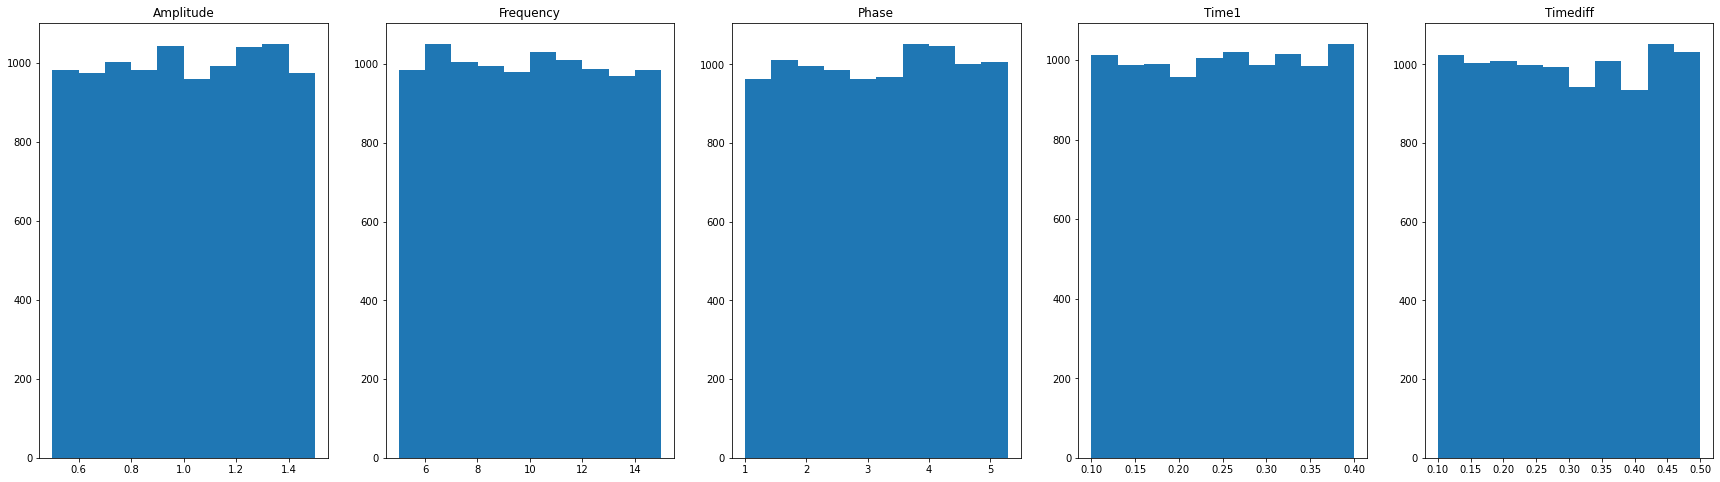

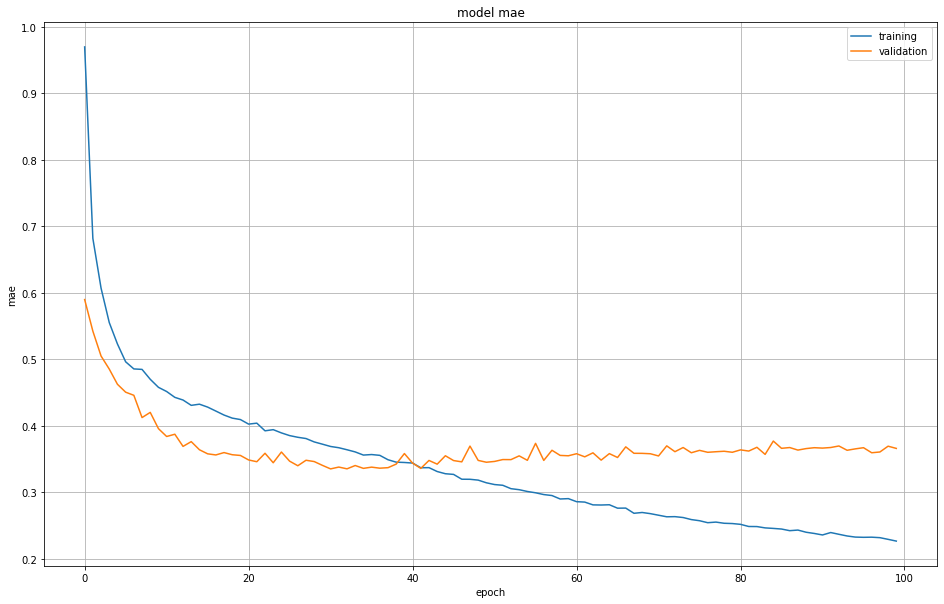

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                

In [58]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=True)
modelname = 'model_2_pulses_timeshift_noisy'
model_2_pulses_timeshift_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

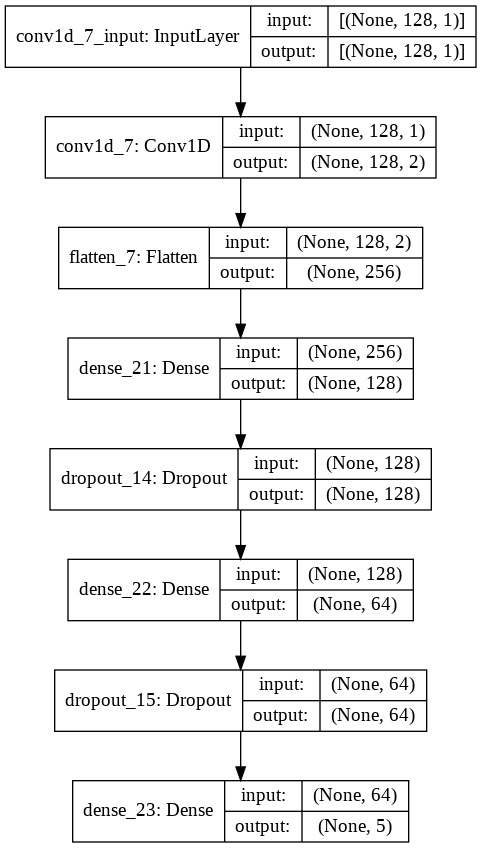

In [59]:
plot_model(model_2_pulses_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 2ms/step - loss: 0.4970 - mse: 0.4970 - mae: 0.3605


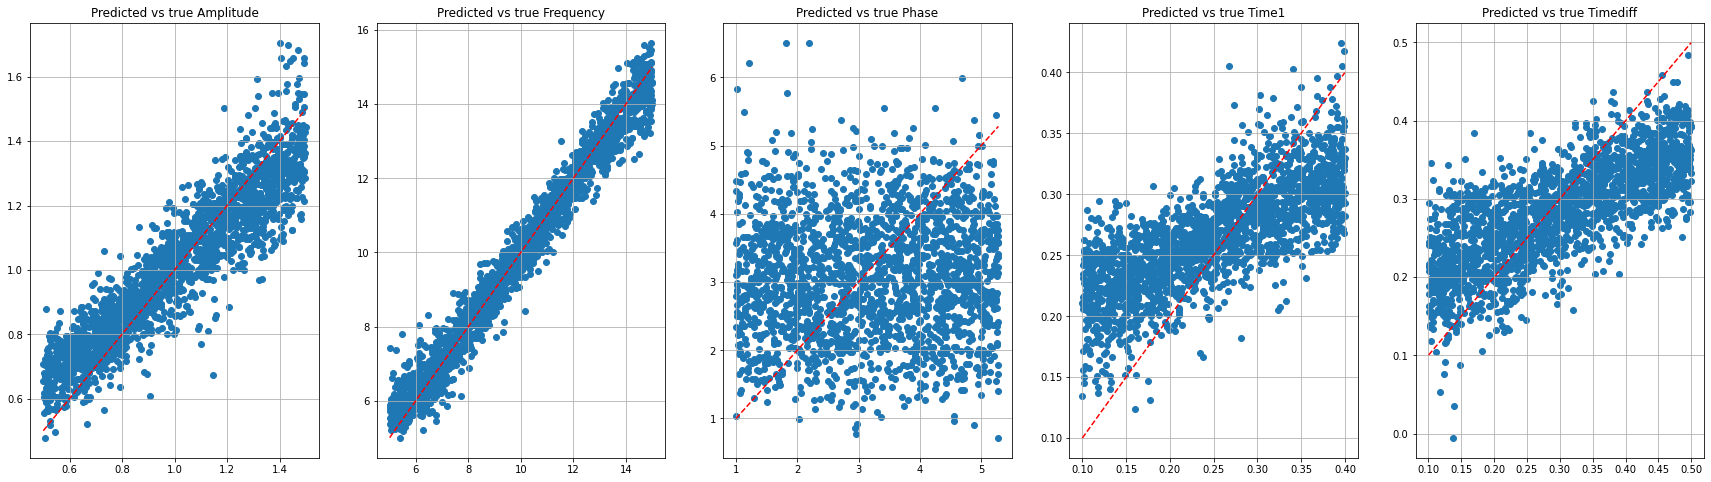

In [60]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [61]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Interfering CW

## Main Section

In [62]:
df_iterations_cw1 = makerandom(dataset_size, source_central_freq=10, source_mag=1, seed=11)
df_iterations_cw2 = makerandom(dataset_size, source_central_freq=10, source_mag=1, seed=22)
df_iterations_cw1.rename(columns={'Amplitude': 'Amplitude_1', 'Frequency': 'Frequency_1', 'Phase': 'Phase_1'}, inplace=True)
df_iterations_cw2.rename(columns={'Amplitude': 'Amplitude_2', 'Frequency': 'Frequency_2', 'Phase': 'Phase_2'}, inplace=True)
df_iterations_interfering_cw = df_iterations_cw1.join(df_iterations_cw2)

In [63]:
cw1 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw1['Amplitude_1'], df_iterations_cw1['Frequency_1'], df_iterations_cw1['Phase_1'])]
cw2 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw2['Amplitude_2'], df_iterations_cw2['Frequency_2'], df_iterations_cw2['Phase_2'])]


In [64]:
cw1_plus_cw2_clean = [row[0] + row[1] for row in zip(cw1, cw2)]

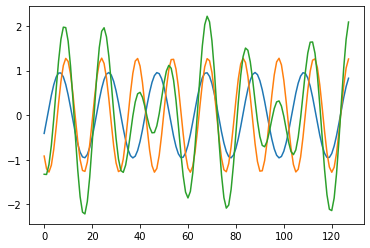

In [65]:
plt.plot(cw1[0])
plt.plot(cw2[0])
plt.plot(cw1_plus_cw2_clean[0])
plt.show()

### Clean

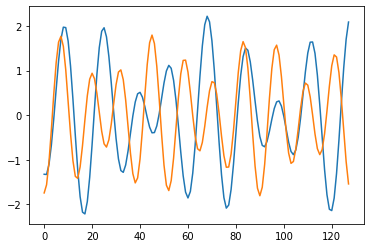

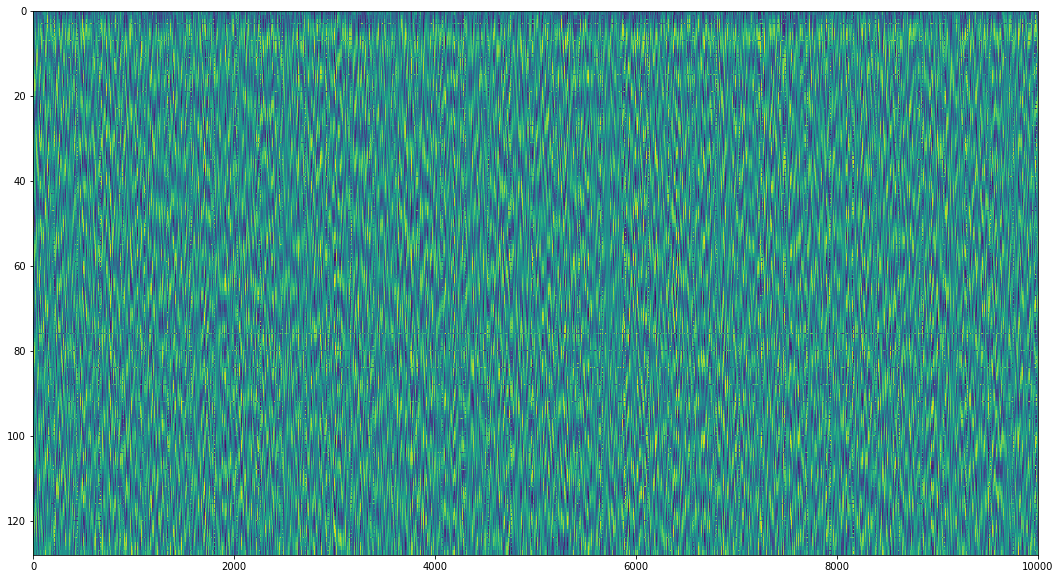

Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 9.7923 - mse: 9.7923 - mae: 2.0272 - val_loss: 3.0724 - val_mse: 3.0724 - val_mae: 1.1519
Epoch 2/100
320/320 [==============================] - 1s 5ms/step - loss: 3.2893 - mse: 3.2893 - mae: 1.2347 - val_loss: 2.3474 - val_mse: 2.3474 - val_mae: 1.0048
Epoch 3/100
320/320 [==============================] - 1s 4ms/step - loss: 2.7635 - mse: 2.7635 - mae: 1.1187 - val_loss: 2.1595 - val_mse: 2.1595 - val_mae: 0.9705
Epoch 4/100
320/320 [==============================] - 1s 4ms/step - loss: 2.5601 - mse: 2.5601 - mae: 1.0641 - val_loss: 2.0739 - val_mse: 2.0739 - val_mae: 0.9599
Epoch 5/100
320/320 [==============================] - 1s 4ms/step - loss: 2.3970 - mse: 2.3970 - mae: 1.0295 - val_loss: 1.9893 - val_mse: 1.9893 - val_mae: 0.9381
Epoch 6/100
320/320 [==============================] - 1s 4ms/step - loss: 2.3105 - mse: 2.3105 - mae: 1.0112 - val_loss: 1.9326 - val_mse: 1.9326 - val_mae: 0.9270
Epoch 7/10

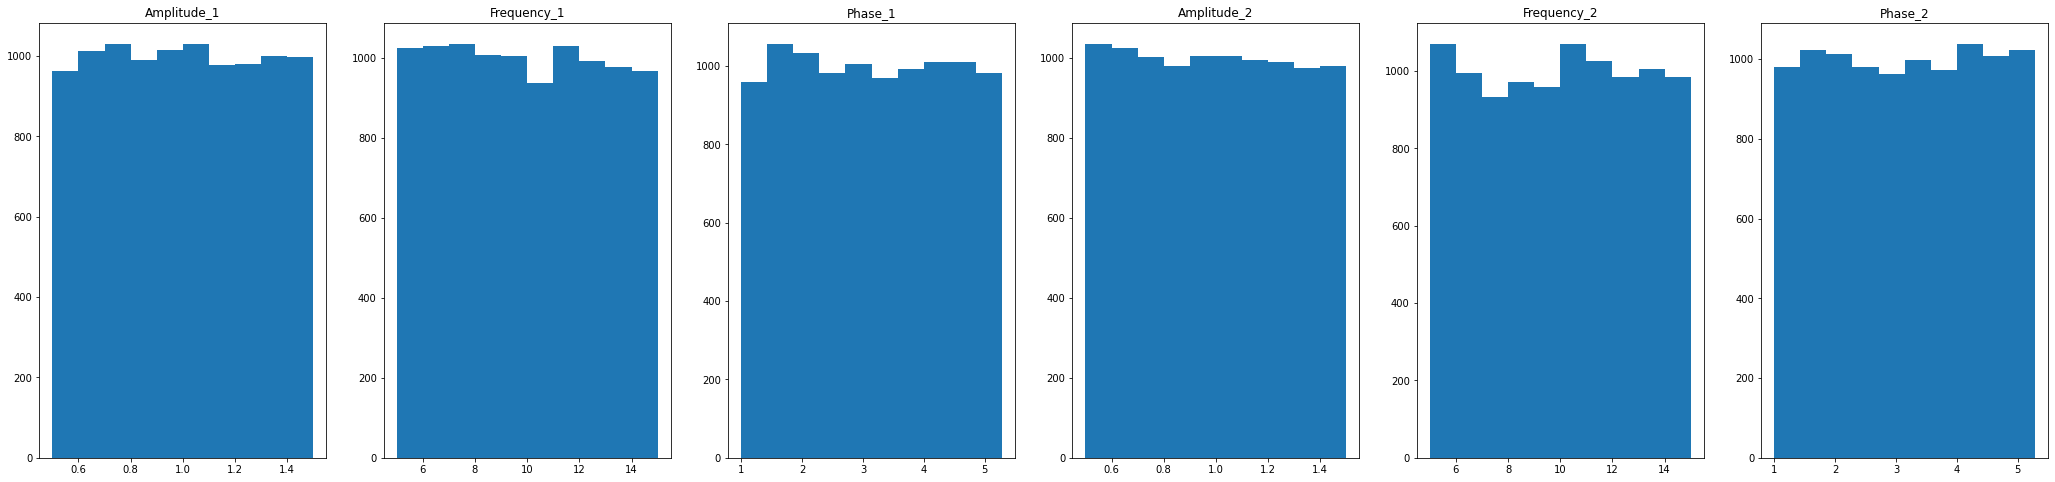

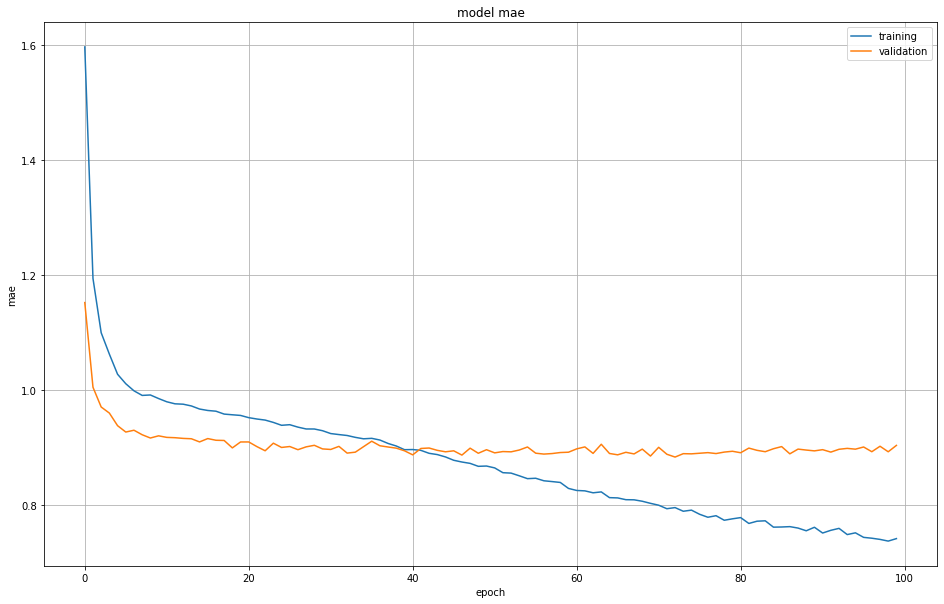

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 6)                

In [66]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw, noiseon=False)
modelname = 'model_interfering_cw_clean'
model_interfering_cw_clean = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

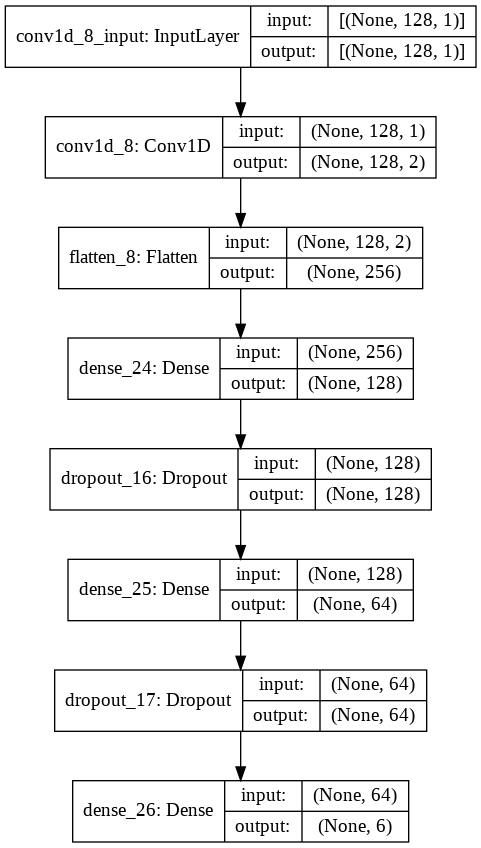

In [67]:
plot_model(model_interfering_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 2.3622 - mse: 2.3622 - mae: 0.9494


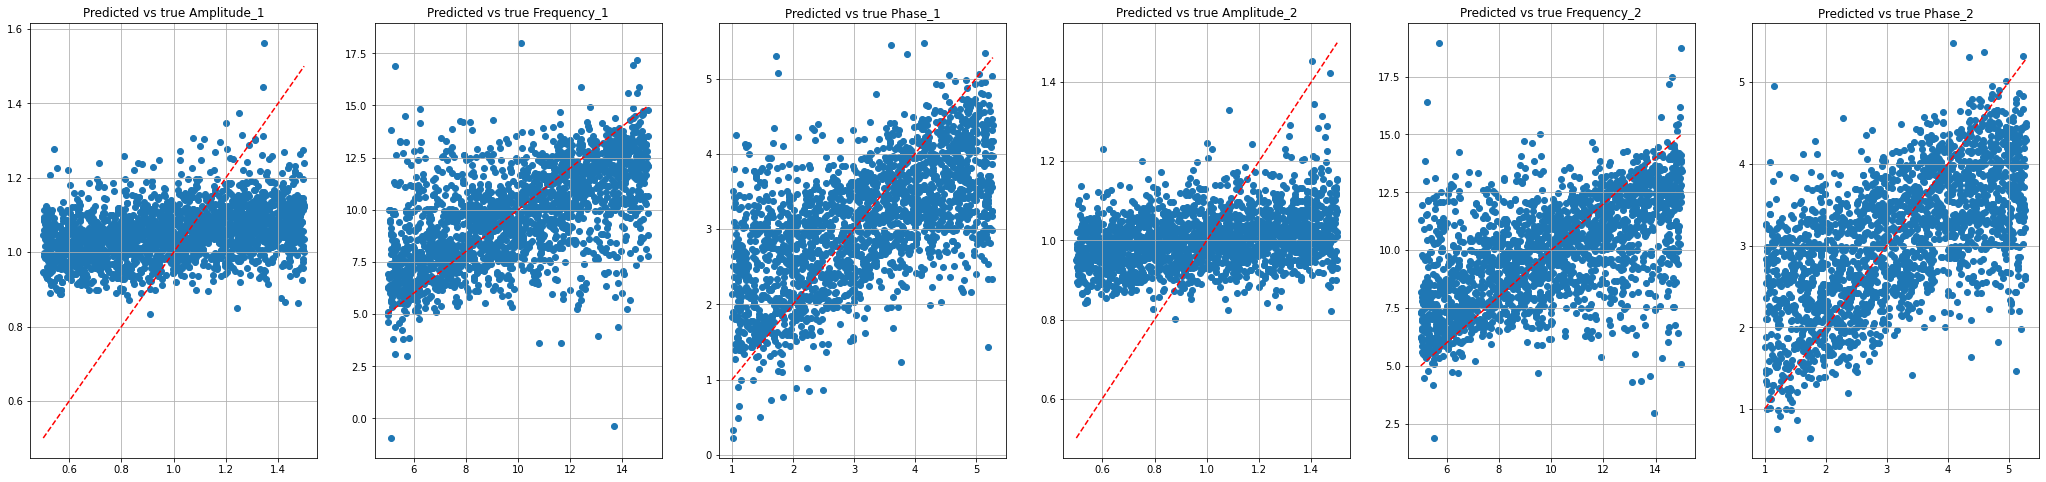

In [68]:
df_y_predict, performance = test_and_predict(model_interfering_cw_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [69]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Noisy

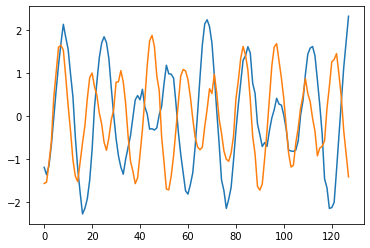

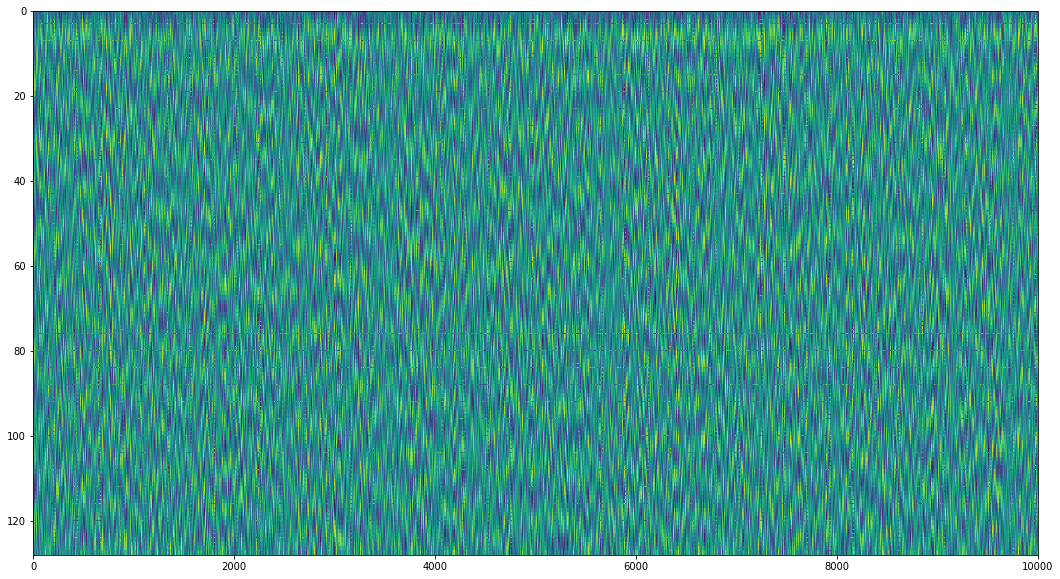

Epoch 1/100
320/320 [==============================] - 4s 9ms/step - loss: 7.2167 - mse: 7.2167 - mae: 1.8395 - val_loss: 2.1056 - val_mse: 2.1056 - val_mae: 0.9663
Epoch 2/100
320/320 [==============================] - 2s 8ms/step - loss: 2.5542 - mse: 2.5542 - mae: 1.1048 - val_loss: 1.9670 - val_mse: 1.9670 - val_mae: 0.9264
Epoch 3/100
320/320 [==============================] - 3s 8ms/step - loss: 2.3498 - mse: 2.3498 - mae: 1.0437 - val_loss: 1.8733 - val_mse: 1.8733 - val_mae: 0.9108
Epoch 4/100
320/320 [==============================] - 2s 8ms/step - loss: 2.2653 - mse: 2.2653 - mae: 1.0132 - val_loss: 1.8937 - val_mse: 1.8937 - val_mae: 0.9050
Epoch 5/100
320/320 [==============================] - 2s 6ms/step - loss: 2.1654 - mse: 2.1654 - mae: 0.9841 - val_loss: 1.8136 - val_mse: 1.8136 - val_mae: 0.8909
Epoch 6/100
320/320 [==============================] - 2s 7ms/step - loss: 2.1192 - mse: 2.1192 - mae: 0.9721 - val_loss: 1.7759 - val_mse: 1.7759 - val_mae: 0.8918
Epoch 7/10

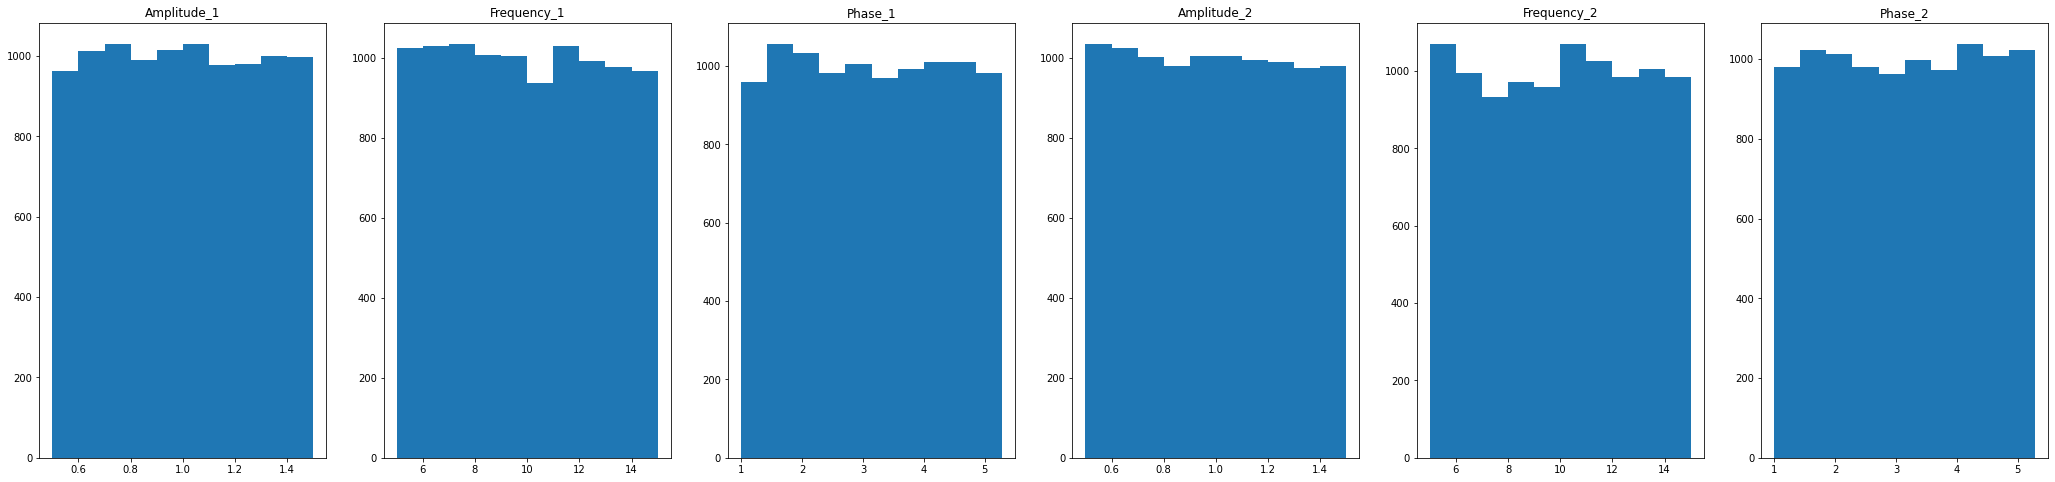

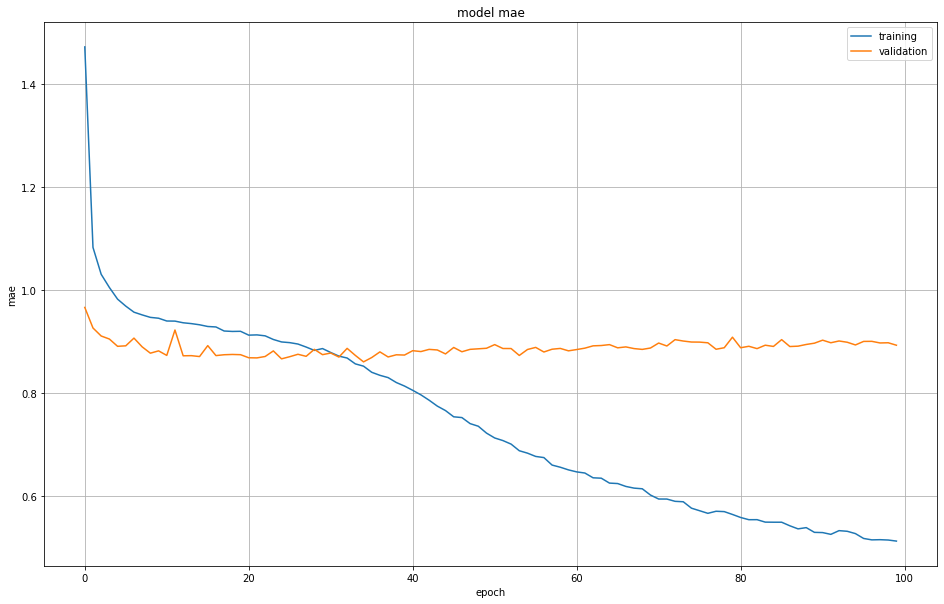

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 128, 6)            198       
_________________________________________________________________
flatten_9 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               98432     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 6)                

In [70]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw, noiseon=True)
modelname = 'model_interfering_cw_clean'
model_interfering_cw_noisy = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models)

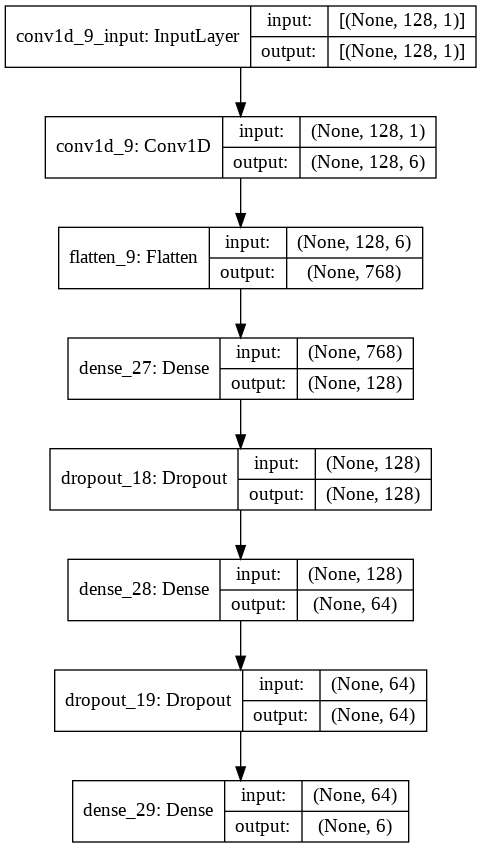

In [71]:
plot_model(model_interfering_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 2.4266 - mse: 2.4266 - mae: 0.9455


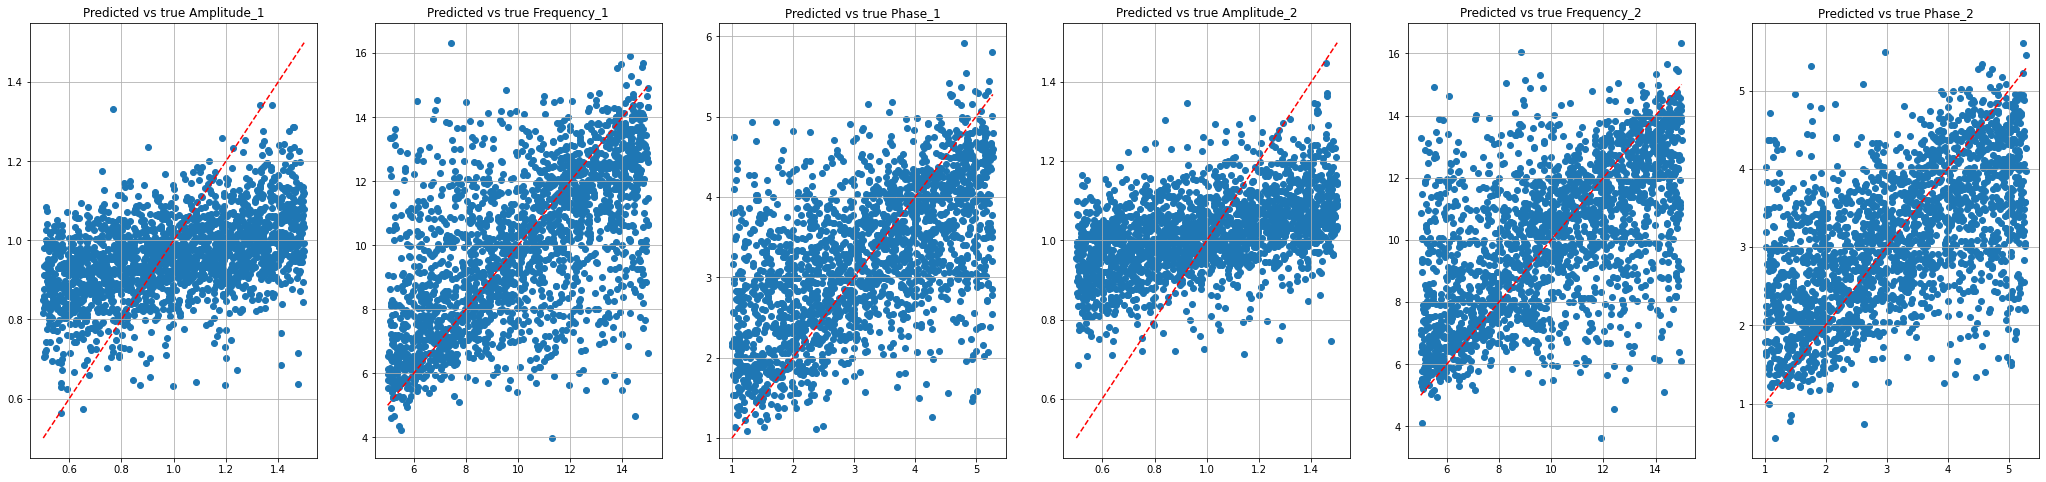

In [72]:
df_y_predict, performance = test_and_predict(model_interfering_cw_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [73]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

# Pre-Processing

## Helper functions

In [74]:
from scipy.signal import hilbert, correlate

In [75]:
def autocorr(array_in):
  no_traces = len(array_in)
  result = np.zeros_like(array_in)
  for i in range(0, no_traces):
    temp = np.correlate(array_in[i], array_in[i], mode='full')
    result[i] = temp[temp.size//2:]
  return result

In [76]:
def hilbert_autocorr(traces):
  traces_hilbert = abs(hilbert(traces))
  traces_autocorr = autocorr(traces)
  traces_hilbert_autocorr = autocorr(traces_hilbert)
  return np.stack((traces, traces_hilbert, traces_autocorr, traces_hilbert_autocorr), axis=-1)

In [77]:
def preprocessing_split_and_plots_2(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  #df_traces = pd.DataFrame(traces)
  plt.plot(traces[0,:,0])
  plt.plot(traces[1,:,0])
  plt.show()
  plt.figure(figsize=(18, 10))
  #plt.pcolormesh(df_traces.T)
  #plt.gca().invert_yaxis()
  #plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(traces, df_iterations, test_size=0.2, random_state=42)
  #X_train = np.expand_dims(X_train, axis=2)
  print(X_train.shape, y_train.shape)
  return X_train, X_test, y_train, y_test

## Envelope Detection and Autocorrelation

Datasets:



1.   traces_clean - Probably no benefit since CW (envelope or autocorr has no meaning)
2.   pulse_traces_clean
3.   pulse_timeshift_traces_clean
4.   pulse_2_timeshift_traces_clean
5.   model_interfering_cw_clean






### Continous Wave

In [78]:
traces_clean_hilbert_autocorr = hilbert_autocorr(traces_clean)

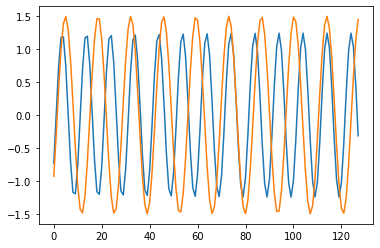

(8000, 128, 4) (8000, 3)
Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 10.1492 - mse: 10.1492 - mae: 2.0868 - val_loss: 0.9322 - val_mse: 0.9322 - val_mae: 0.6862
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.2482 - mse: 1.2482 - mae: 0.8279 - val_loss: 0.4591 - val_mse: 0.4591 - val_mae: 0.4850
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.8298 - mse: 0.8298 - mae: 0.6506 - val_loss: 0.2730 - val_mse: 0.2730 - val_mae: 0.3693
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.6545 - mse: 0.6545 - mae: 0.5682 - val_loss: 0.6235 - val_mse: 0.6235 - val_mae: 0.5506
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5762 - mse: 0.5762 - mae: 0.5240 - val_loss: 0.1839 - val_mse: 0.1839 - val_mae: 0.3046
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4520 - mse: 0.4520 - mae: 0.4639 - val_loss: 0.3355 - val_mse: 0.3355 -

<Figure size 1296x720 with 0 Axes>

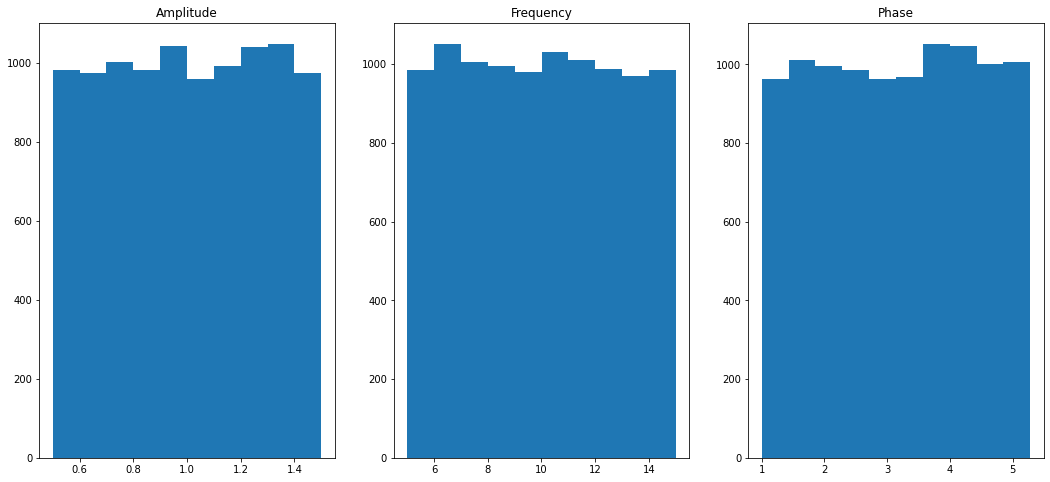

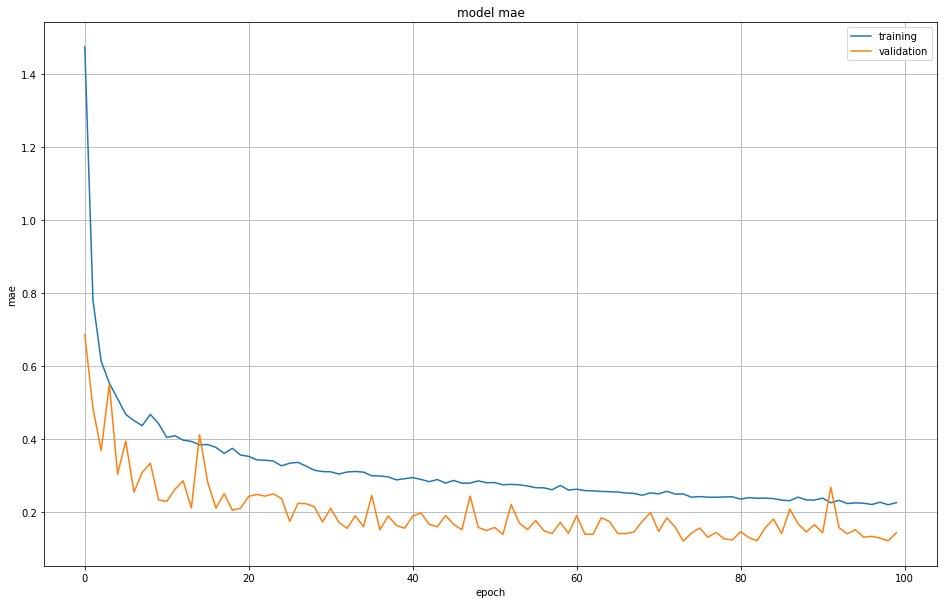

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 3)               

In [79]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(traces_clean_hilbert_autocorr, df_iterations, noiseon=False)
modelname = 'model_cw_clean_hilbert_autocorr'
model_cw_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

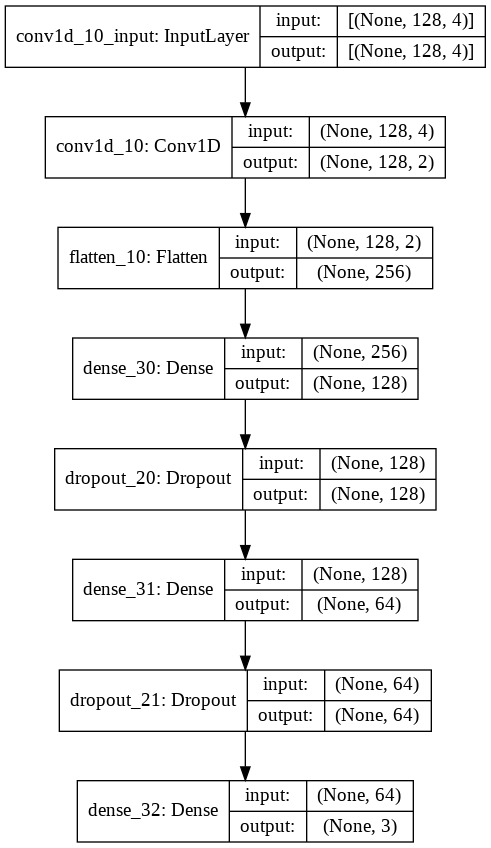

In [80]:
plot_model(model_cw_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0374 - mse: 0.0374 - mae: 0.1432


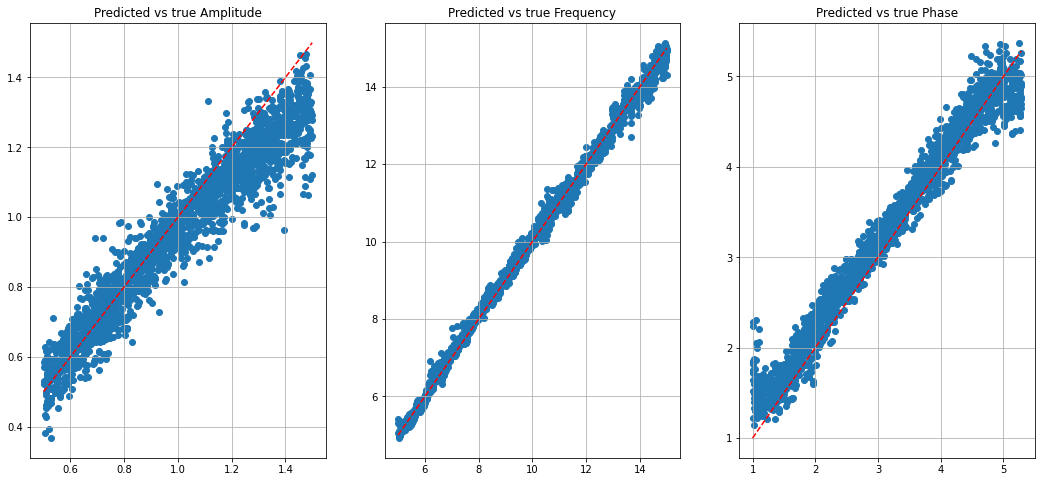

In [81]:
df_y_predict, performance = test_and_predict(model_cw_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [82]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Signal Pulse

In [83]:
pulse_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_traces_clean)

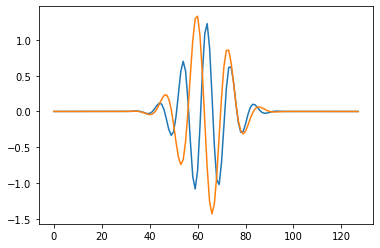

(8000, 128, 4) (8000, 3)
Epoch 1/100
320/320 [==============================] - 3s 7ms/step - loss: 6.2850 - mse: 6.2850 - mae: 1.6379 - val_loss: 0.5853 - val_mse: 0.5853 - val_mae: 0.5038
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.0684 - mse: 1.0684 - mae: 0.7704 - val_loss: 0.5774 - val_mse: 0.5774 - val_mae: 0.5034
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9237 - mse: 0.9237 - mae: 0.7046 - val_loss: 0.6427 - val_mse: 0.6427 - val_mae: 0.5528
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9154 - mse: 0.9154 - mae: 0.6963 - val_loss: 0.5272 - val_mse: 0.5272 - val_mae: 0.4390
Epoch 5/100
320/320 [==============================] - 2s 6ms/step - loss: 0.8451 - mse: 0.8451 - mae: 0.6629 - val_loss: 0.6112 - val_mse: 0.6112 - val_mae: 0.5419
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.8257 - mse: 0.8257 - mae: 0.6463 - val_loss: 0.5494 - val_mse: 0.5494 - v

<Figure size 1296x720 with 0 Axes>

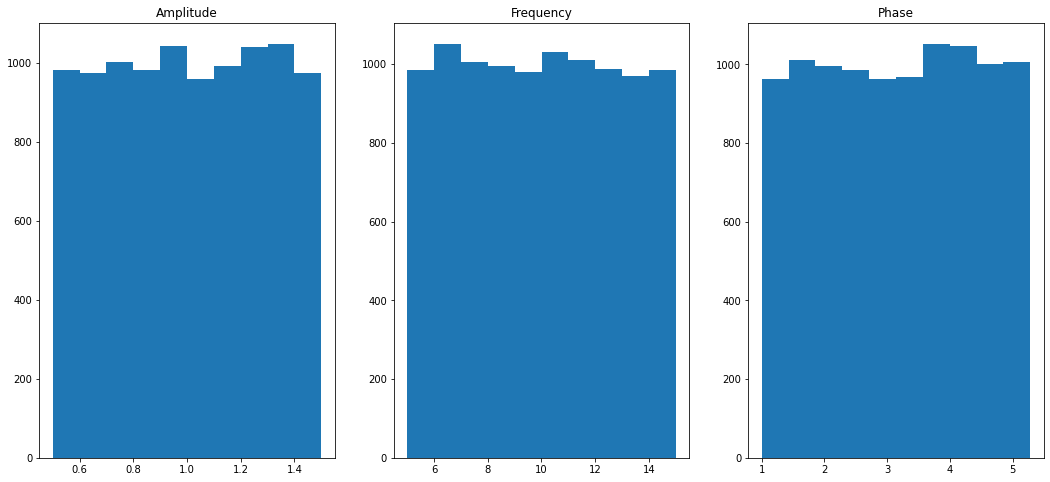

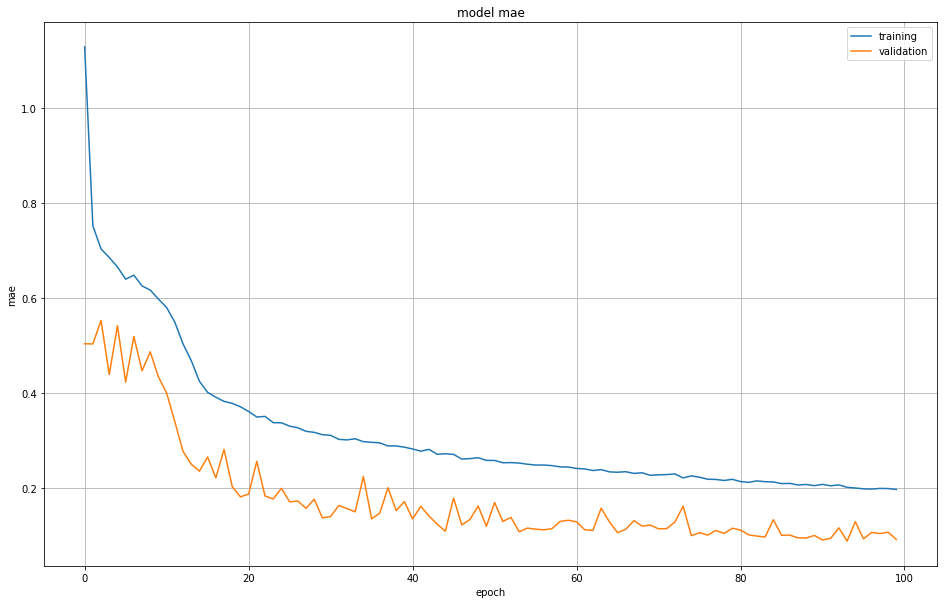

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)               

In [84]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_clean_hilbert_autocorr, df_iterations, noiseon=False)
modelname = 'model_pulse_clean_hilbert_autocorr'
model_pulse_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

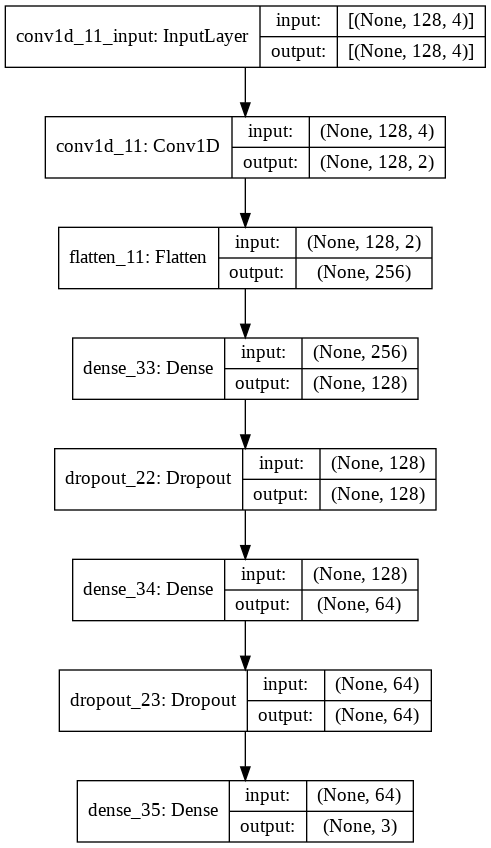

In [85]:
plot_model(model_pulse_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0922


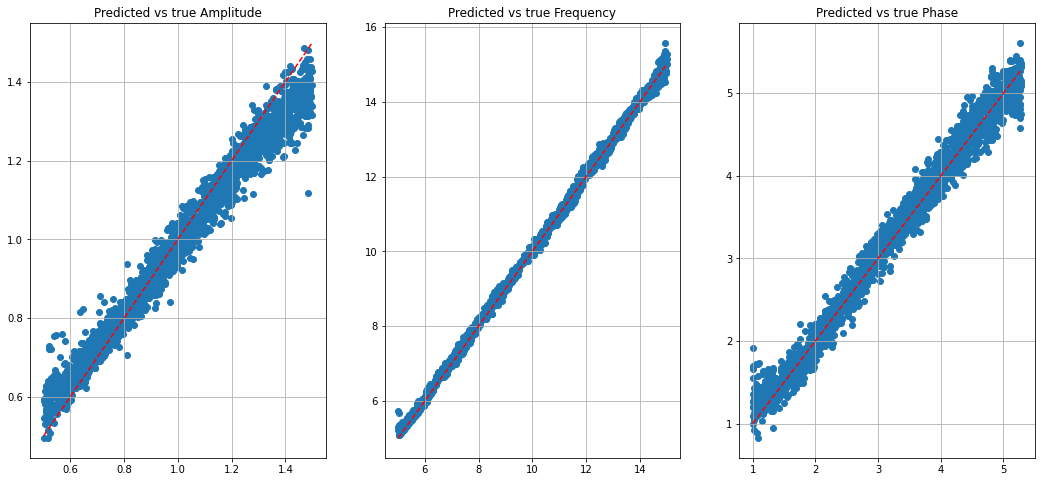

In [86]:
df_y_predict, performance = test_and_predict(model_pulse_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [87]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

In [88]:
def add_noise(traces_clean, noiselevel=0.1):
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
    return traces

In [89]:
pulse_traces_noisy = add_noise(pulse_traces_clean)

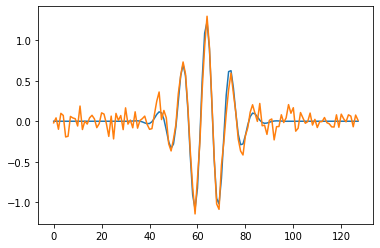

In [90]:
plt.plot(pulse_traces_clean[0])
plt.plot(pulse_traces_noisy[0])
plt.show()

In [91]:
pulse_traces_noisy_hilbert_autocorr = hilbert_autocorr(pulse_traces_noisy)

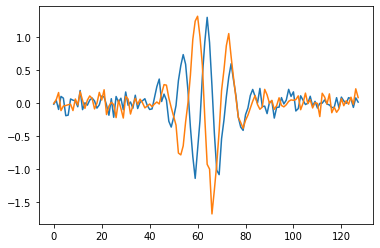

(8000, 128, 4) (8000, 3)
Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 8.6240 - mse: 8.6240 - mae: 1.8380 - val_loss: 1.0041 - val_mse: 1.0041 - val_mae: 0.7368
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 1.2252 - mse: 1.2252 - mae: 0.8136 - val_loss: 0.6203 - val_mse: 0.6203 - val_mae: 0.5266
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 1.0098 - mse: 1.0098 - mae: 0.7306 - val_loss: 0.7227 - val_mse: 0.7227 - val_mae: 0.5948
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9945 - mse: 0.9945 - mae: 0.7218 - val_loss: 0.8296 - val_mse: 0.8296 - val_mae: 0.6651
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9329 - mse: 0.9329 - mae: 0.6887 - val_loss: 0.5986 - val_mse: 0.5986 - val_mae: 0.5126
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.9266 - mse: 0.9266 - mae: 0.6831 - val_loss: 0.7696 - val_mse: 0.7696 - v

<Figure size 1296x720 with 0 Axes>

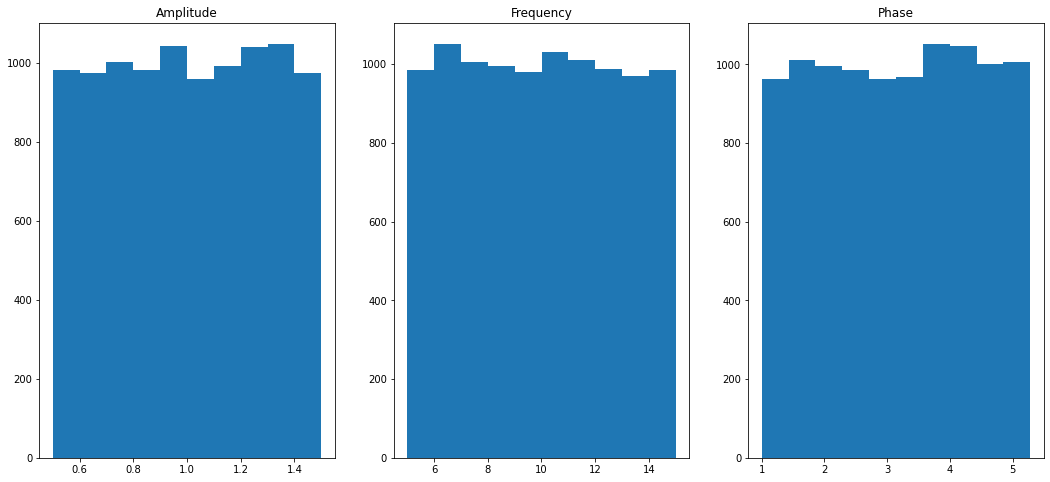

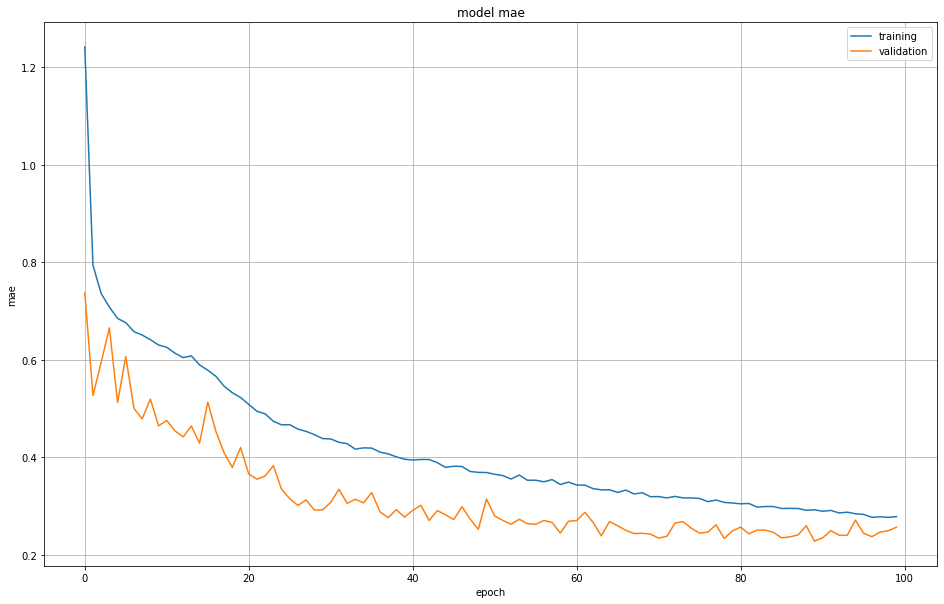

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 3)               

In [92]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_noisy_hilbert_autocorr, df_iterations, noiseon=False) # noiseon=False since noise is alreay added.
modelname = 'model_pulse_noisy_hilbert_autocorr'
model_pulse_noisy_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

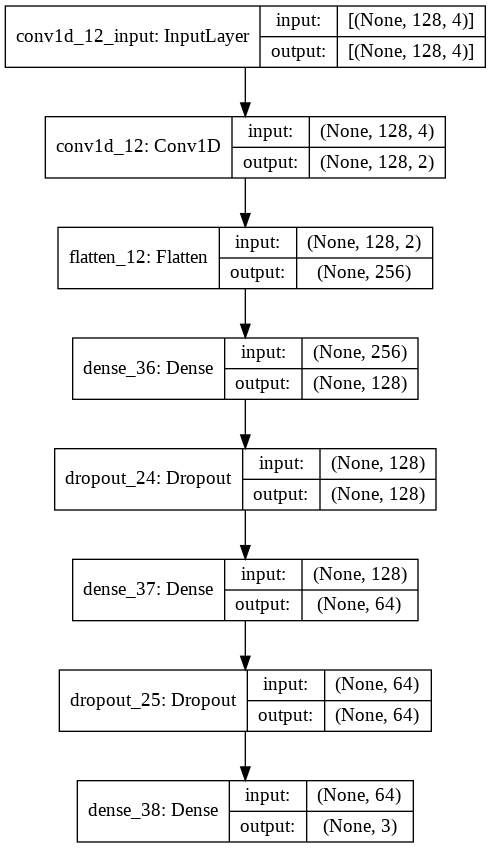

In [93]:
plot_model(model_pulse_noisy_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.1597 - mse: 0.1597 - mae: 0.2554


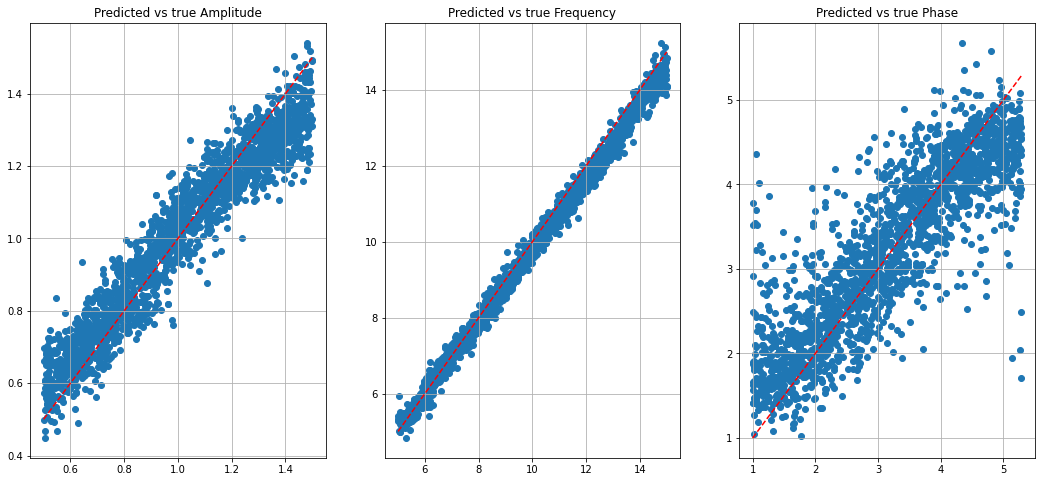

In [94]:
df_y_predict, performance = test_and_predict(model_pulse_noisy_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [95]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### Pulse with Timeshift

In [96]:
pulse_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_timeshift_traces_clean)

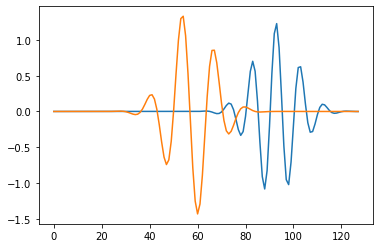

(8000, 128, 4) (8000, 4)
Epoch 1/100
320/320 [==============================] - 3s 6ms/step - loss: 6.4121 - mse: 6.4121 - mae: 1.5492 - val_loss: 0.2593 - val_mse: 0.2593 - val_mae: 0.2947
Epoch 2/100
320/320 [==============================] - 2s 5ms/step - loss: 0.6984 - mse: 0.6984 - mae: 0.5916 - val_loss: 0.1917 - val_mse: 0.1917 - val_mae: 0.2533
Epoch 3/100
320/320 [==============================] - 2s 5ms/step - loss: 0.5056 - mse: 0.5056 - mae: 0.4813 - val_loss: 0.1749 - val_mse: 0.1749 - val_mae: 0.2711
Epoch 4/100
320/320 [==============================] - 2s 5ms/step - loss: 0.4281 - mse: 0.4281 - mae: 0.4257 - val_loss: 0.0767 - val_mse: 0.0767 - val_mae: 0.1590
Epoch 5/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3592 - mse: 0.3592 - mae: 0.3839 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1548
Epoch 6/100
320/320 [==============================] - 2s 5ms/step - loss: 0.3253 - mse: 0.3253 - mae: 0.3597 - val_loss: 0.1105 - val_mse: 0.1105 - v

<Figure size 1296x720 with 0 Axes>

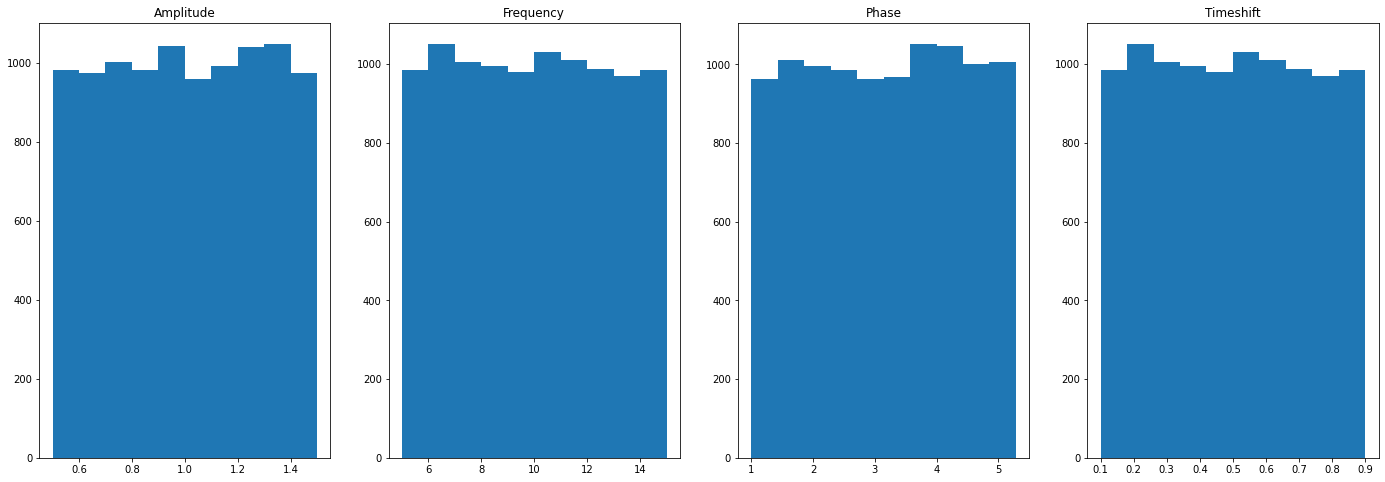

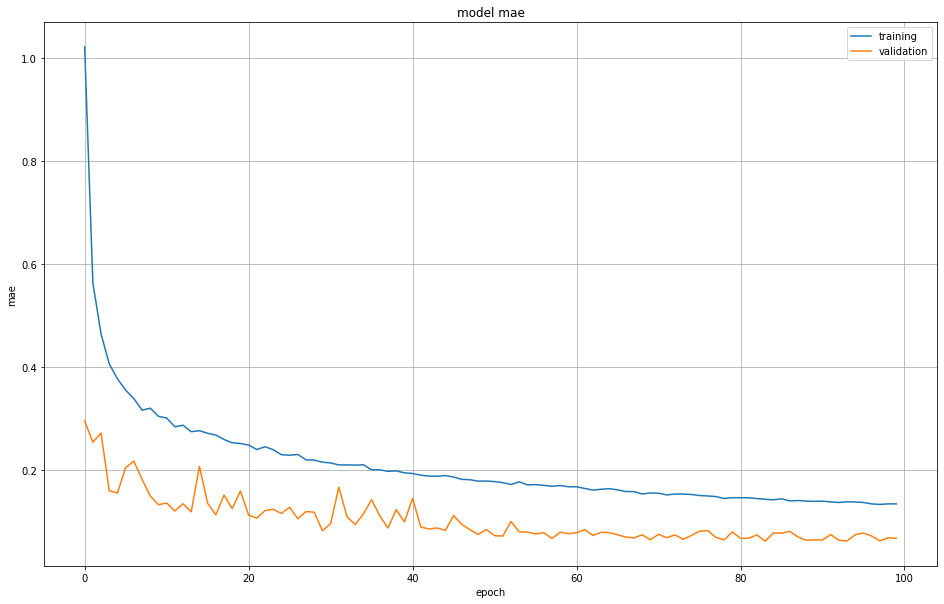

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_13 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 4)               

In [97]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_timeshift_traces_clean_hilbert_autocorr, df_iterations_w_timeshifts, noiseon=False)
modelname = 'model_pulse_timeshift_clean_hilbert_autocorr'
model_pulse_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

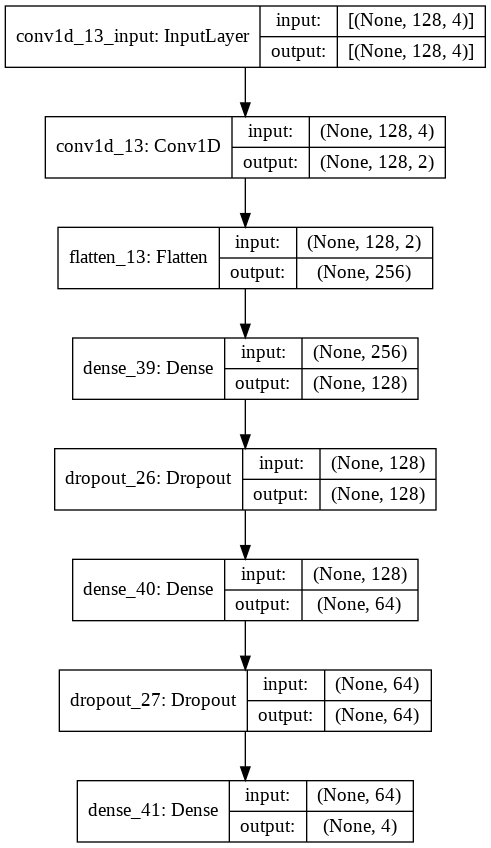

In [98]:
plot_model(model_pulse_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0659


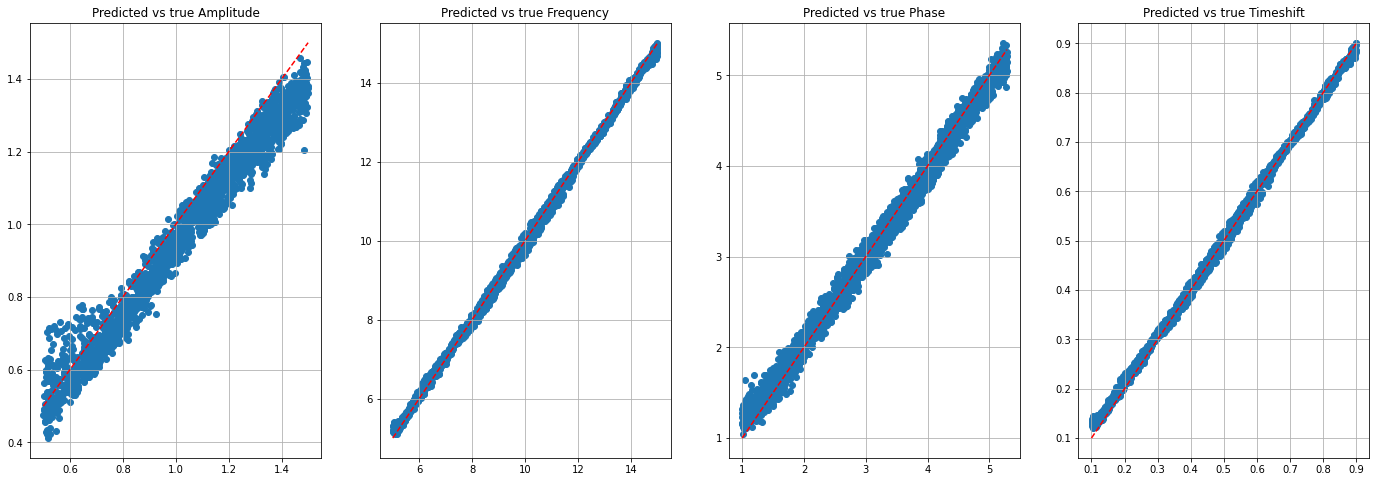

In [99]:
df_y_predict, performance = test_and_predict(model_pulse_timeshift_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [100]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

### 2 Pulses with variable timeshift

In [109]:
pulse_2_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_2_timeshift_traces_clean)

In [110]:
pulse_2_timeshift_traces_clean_hilbert_autocorr.shape

(10000, 128, 4)

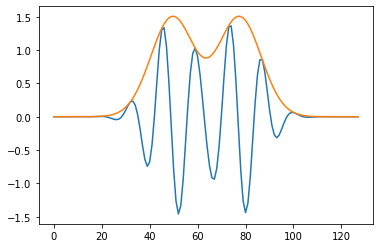

In [111]:
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,0])
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,1])

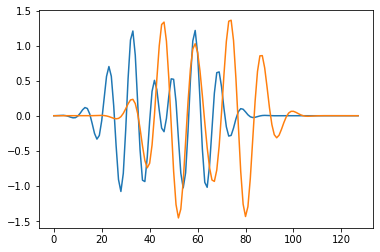

(8000, 128, 4) (8000, 5)
Epoch 1/100
320/320 [==============================] - 3s 7ms/step - loss: 6.6622 - mse: 6.6622 - mae: 1.4704 - val_loss: 0.5927 - val_mse: 0.5927 - val_mae: 0.4729
Epoch 2/100
320/320 [==============================] - 2s 6ms/step - loss: 0.8142 - mse: 0.8142 - mae: 0.6137 - val_loss: 0.4475 - val_mse: 0.4475 - val_mae: 0.3973
Epoch 3/100
320/320 [==============================] - 2s 6ms/step - loss: 0.6597 - mse: 0.6597 - mae: 0.5276 - val_loss: 0.3996 - val_mse: 0.3996 - val_mae: 0.3645
Epoch 4/100
320/320 [==============================] - 2s 7ms/step - loss: 0.6092 - mse: 0.6092 - mae: 0.4867 - val_loss: 0.3931 - val_mse: 0.3931 - val_mae: 0.3633
Epoch 5/100
320/320 [==============================] - 2s 7ms/step - loss: 0.5637 - mse: 0.5637 - mae: 0.4632 - val_loss: 0.3712 - val_mse: 0.3712 - val_mae: 0.3420
Epoch 6/100
320/320 [==============================] - 2s 6ms/step - loss: 0.5461 - mse: 0.5461 - mae: 0.4519 - val_loss: 0.3736 - val_mse: 0.3736 - v

<Figure size 1296x720 with 0 Axes>

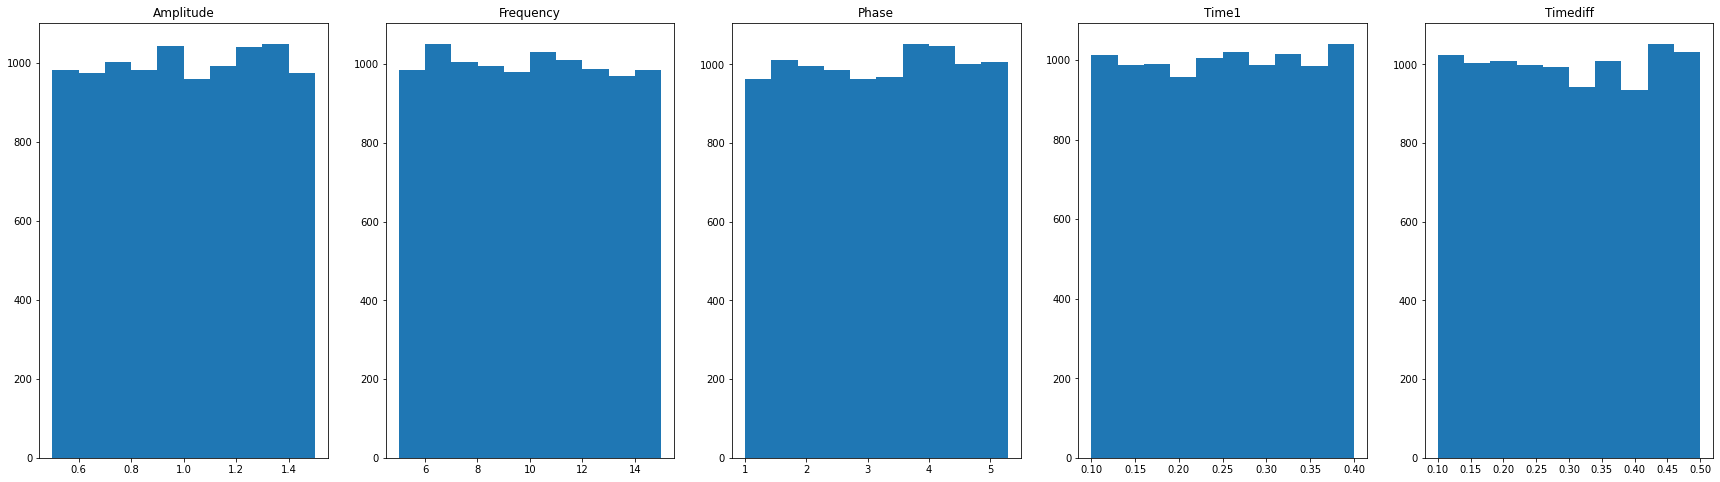

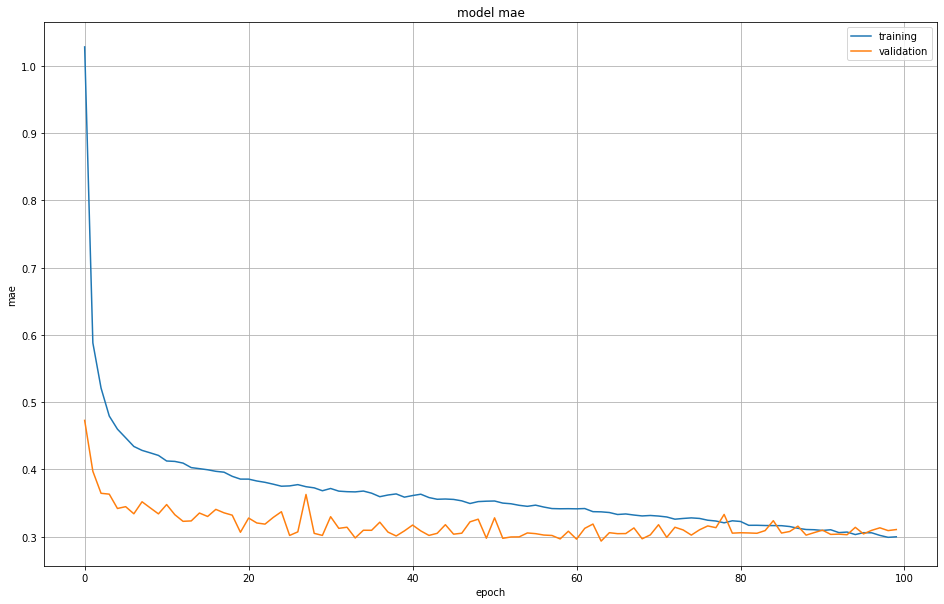

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_15 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 5)               

In [112]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_2_timeshift_traces_clean_hilbert_autocorr, df_2_pulses_timeshift_iterations_combined, noiseon=False)
modelname = 'model_2_pulses_timeshift_clean_hilbert_autocorr'
model_2_pulses_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+modelname, loadmodel=load_models, autoscale=auto_scale)

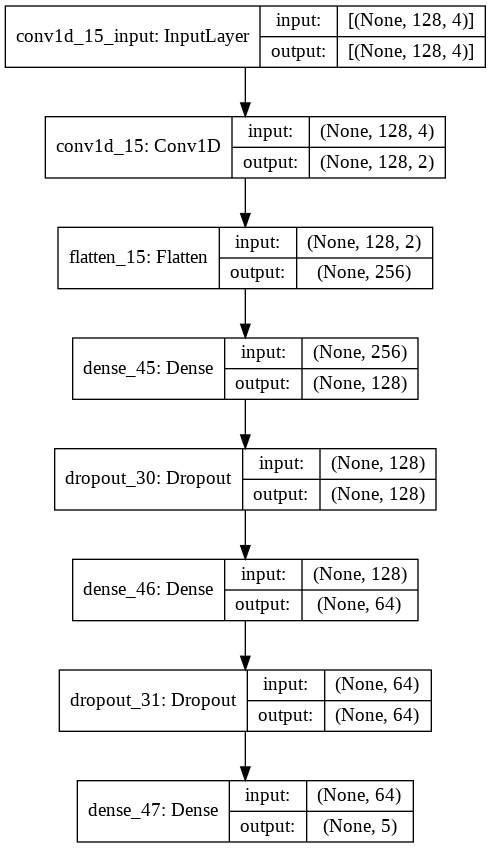

In [113]:
plot_model(model_2_pulses_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.3721 - mse: 0.3721 - mae: 0.3118


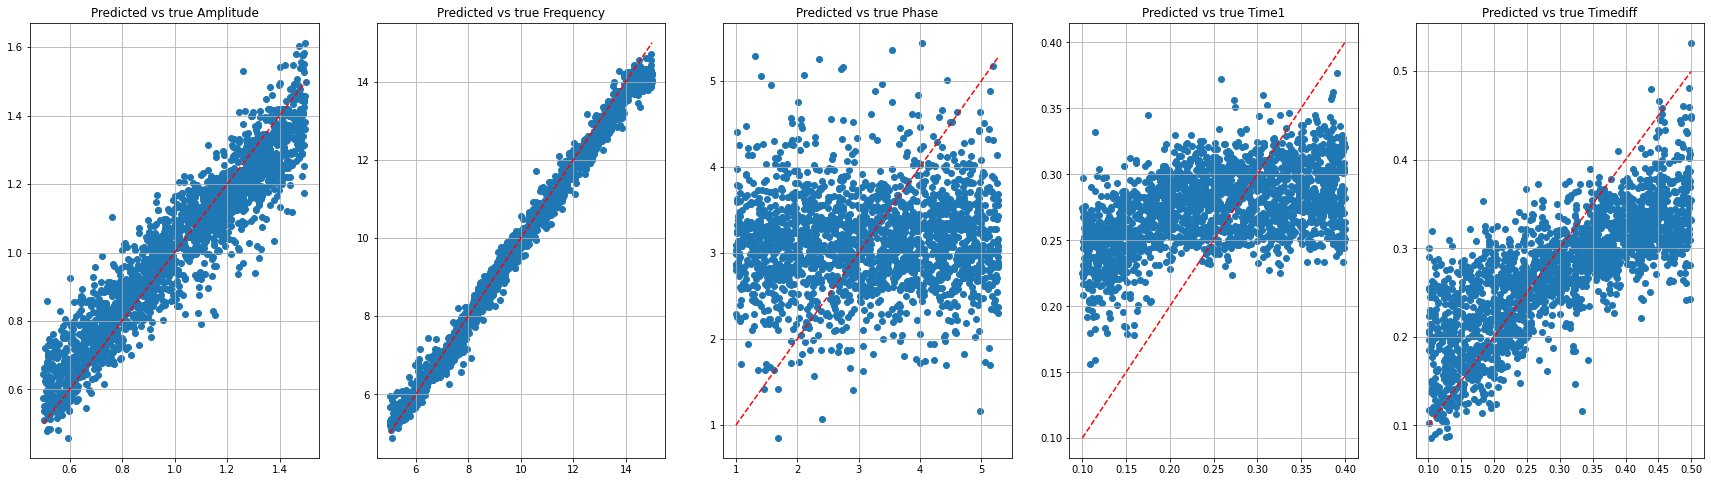

In [114]:
df_y_predict, performance = test_and_predict(model_2_pulses_timeshift_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [115]:
df_performance = addperformance(modelname, performance, df_performance=df_performance)

In [116]:
df_performance

ModelName  ...       MAE
0                                    model_cw_clean  ...  0.076196
1                                    model_cw_noisy  ...  0.086139
2                                 model_pulse_clean  ...  0.116551
3                                 model_pulse_noisy  ...  0.285459
4                       model_pulse_timeshift_clean  ...  0.061861
5                       model_pulse_timeshift_noisy  ...  0.092088
6                    model_2_pulses_timeshift_clean  ...  0.309142
7                    model_2_pulses_timeshift_noisy  ...  0.360455
8                        model_interfering_cw_clean  ...  0.949450
9                        model_interfering_cw_clean  ...  0.945514
10                  model_cw_clean_hilbert_autocorr  ...  0.143226
11               model_pulse_clean_hilbert_autocorr  ...  0.092218
12               model_pulse_noisy_hilbert_autocorr  ...  0.255430
13     model_pulse_timeshift_clean_hilbert_autocorr  ...  0.065935
14  model_2_pulses_timeshift_clean_hilbert_autocorr  ...  0.301346
15  model_2_pulses_timeshift_clean_hilbert_autocorr  ...  0.311791

[16 rows x 4 columns]